# Data Loader - H8 and MODIS

In [1]:
# TODO: consider splitting script into a module

import os
import pandas as pd
import numpy as np
import xarray as xr
import datetime

def read_H8_MODIS_byDate(date, modis_res, modis_sat, data_path):
    '''
    TODO: comments
    '''
    
    H8_PARENT_DIR = 'H8_MODIS_2019-2020'
    H8_MODIS_DIR = f'H8_{modis_sat}_{modis_res}'
    H8_MODIS_FILENAME = f'H8_{modis_sat}_{modis_res}_Aus_0.05_{date}.nc'
    H8_MODIS_PATH = os.path.join(data_path, H8_PARENT_DIR, H8_MODIS_DIR, H8_MODIS_FILENAME)
    
    df = xr.open_dataset(H8_MODIS_PATH).to_dataframe()
    df = df.drop(columns=['solar_azimuth_angle','solar_zenith_angle'])
    
    return df

def read_MODIS_byDate(date, modis_res, modis_sat, data_path):
    '''
    TODO: comments
    '''
    
    MODIS_PARENT_DIR = 'MODIS_L2_Aus_2019-2020'
    MODIS_FILENAME = f'{modis_sat}_{modis_res}_Aus_0.05_{date}.nc'
    MODIS_PATH = os.path.join(data_path, MODIS_PARENT_DIR, MODIS_FILENAME)
    
    df = xr.open_dataset(MODIS_PATH).drop_dims(['corner','file']).to_dataframe()
    
    return df

def concat_rows(df_list):
    '''
    TODO: comments
    '''
    
    for i in range(1,len(df_list)):
        if list(df_list[i].columns) != list(df_list[0].columns) and (not df_list[0].empty and not df_list[i].empty):
            raise Exception('ERROR: Columns do not line up in the dataframes that are to be concatenated. Data may need to be fixed before proceeding.')
            
    return pd.concat(df_list, axis=0)

def check_lat_lon(df_H8, df_MODIS):
    '''
    TODO: comments
    '''
    
    if list(df_H8.lat) != list(df_MODIS.Latitude) or list(df_H8.lon) != list(df_MODIS.Longitude):
        raise Exception('ERROR: Lat/Lon rows do not line up between the two dataframes.')

def load_data_byDate(date_str, modis_res, data_dir):
    '''
    TODO: comments
    '''
    
    df_H8_MOD04 = read_H8_MODIS_byDate(date_str, modis_res, 'MOD04', data_dir)
    df_H8_MYD04 = read_H8_MODIS_byDate(date_str, modis_res, 'MYD04', data_dir)
    df_H8 = concat_rows([df_H8_MOD04, df_H8_MYD04])
    
    df_MOD04 = read_MODIS_byDate(date_str, modis_res, 'MOD04', data_dir)
    df_MYD04 = read_MODIS_byDate(date_str, modis_res, 'MYD04', data_dir)
    df_MODIS = concat_rows([df_MOD04, df_MYD04])
    
    check_lat_lon(df_H8, df_MODIS)
    
    return df_H8, df_MODIS

def generate_dates(years, days):
    '''
    TODO: comments
    '''
    
    for year in years:
        for month in range(1, 13):
            for day in days:
                yield datetime.date(year, month, day).strftime("%Y-%m-%d")

def load_data(dates_str, modis_res, data_dir, sample_frac=1):
    '''
    TODO: comments
    '''
    
    df_H8 = pd.DataFrame()
    df_MODIS = pd.DataFrame()
    
    for date_str in dates_str:
                
        df_H8_daily, df_MODIS_daily = load_data_byDate(date_str, modis_res, data_dir)
        
        if sample_frac != 1:
            n = len(df_H8_daily)
            sample_size = int(n * sample_frac)
            sample_idx = np.random.choice(n, size=sample_size, replace=False)
            
            df_H8_daily = df_H8_daily.iloc[sample_idx]
            df_MODIS_daily = df_MODIS_daily.iloc[sample_idx]

        df_H8 = concat_rows([df_H8, df_H8_daily])
        df_MODIS = concat_rows([df_MODIS, df_MODIS_daily])
                
    return df_H8, df_MODIS

In [2]:
PARAM_DATA_YEARS = [2019]
PARAM_TRAIN_DAYSOFMONTH = [1,10,20]
PARAM_VAL_DAYSOFMONTH = [8,16]
PARAM_HOLDOUT_DAYSOFMONTH = [28]
PARAM_MODIS_RES = 'L2'
PARAM_DATA_DIR = '/Users/sunfuhan/Desktop/capstone/code_s2'  # change this to the directory path where your H8 and MODIS files are located

PARAM_SAMPLE_FRAC = 0.03  # fraction of data sampled into our sets, change to 1 for no further sampling
# PARAM_SAMPLE_FRAC = 1

np.random.seed(111)

df_H8_train, df_MODIS_train = load_data(generate_dates(PARAM_DATA_YEARS, PARAM_TRAIN_DAYSOFMONTH), 
                                        PARAM_MODIS_RES, 
                                        PARAM_DATA_DIR,
                                        PARAM_SAMPLE_FRAC)

df_H8_val, df_MODIS_val = load_data(generate_dates(PARAM_DATA_YEARS, PARAM_VAL_DAYSOFMONTH), 
                                    PARAM_MODIS_RES, 
                                    PARAM_DATA_DIR,
                                    PARAM_SAMPLE_FRAC)

df_H8_holdout, df_MODIS_holdout = load_data(generate_dates(PARAM_DATA_YEARS, PARAM_HOLDOUT_DAYSOFMONTH), 
                                            PARAM_MODIS_RES, 
                                            PARAM_DATA_DIR,
                                            PARAM_SAMPLE_FRAC)

In [3]:
print('train size:', len(df_H8_train))
print('val size:', len(df_H8_val))
print('holdout size:', len(df_H8_holdout))

train size: 49193
val size: 32656
holdout size: 14900


# Sample usage - e.g. for modelling

In [4]:
feature_cols = [
    # 'channel_0001_brf',
    'channel_0001_scaled_radiance',
    # 'channel_0002_brf',
    'channel_0002_scaled_radiance',
    # 'channel_0003_brf',
    'channel_0003_scaled_radiance',
    # 'channel_0004_brf',
    'channel_0004_scaled_radiance',
    # 'channel_0005_brf',
    'channel_0005_scaled_radiance',
    # 'channel_0006_brf',
    'channel_0006_scaled_radiance',
    'channel_0007_brightness_temperature',
    'channel_0008_brightness_temperature',
    'channel_0009_brightness_temperature',
    'channel_0010_brightness_temperature',
    'channel_0011_brightness_temperature',
    'channel_0012_brightness_temperature',
    'channel_0013_brightness_temperature',
    'channel_0014_brightness_temperature',
    'channel_0015_brightness_temperature',
    'channel_0016_brightness_temperature',
]

response_col = 'AOD_550_Dark_Target_Deep_Blue_Combined'

X_train = df_H8_train[feature_cols]
y_train = df_MODIS_train[response_col]
X_val = df_H8_val[feature_cols]
y_val = df_MODIS_val[response_col]
X_holdout = df_H8_holdout[feature_cols]
y_holdout = df_MODIS_holdout[response_col]

In [6]:
train = pd.concat([X_train, y_train],axis=1)
val =  pd.concat([X_val, y_val],axis=1)
holdout = pd.concat([X_holdout, y_holdout],axis=1)
train = train.dropna()
val = val.dropna()
holdout = holdout.dropna()
train

channel_0001_scaled_radiance  channel_0002_scaled_radiance  \
sounding                                                               
5186                          0.159180                      0.159180   
9478                          0.129883                      0.119141   
16433                         0.096680                      0.086914   
1481                          0.125000                      0.111328   
7793                          0.156250                      0.148438   
...                                ...                           ...   
6145                          0.126953                      0.123047   
12621                         0.095703                      0.088867   
7088                          0.102539                      0.087891   
20432                         0.117188                      0.098633   
12998                         0.092773                      0.079102   

          channel_0003_scaled_radiance  channel_0004_scaled_radiance  \
sounding                                                               
5186                          0.274414                      0.383789   
9478                          0.161133                      0.265625   
16433                         0.139648                      0.208984   
1481                          0.100586                      0.249023   
7793                          0.247070                      0.326172   
...                                ...                           ...   
6145                          0.164062                      0.236328   
12621                         0.166016                      0.252930   
7088                          0.154297                      0.178711   
20432                         0.136719                      0.206055   
12998                         0.113281                      0.187500   

          channel_0005_scaled_radiance  channel_0006_scaled_radiance  \
sounding                                                               
5186                          0.539062                      0.382812   
9478                          0.320312                      0.179688   
16433                         0.320312                      0.242188   
1481                          0.203125                      0.093750   
7793                          0.500000                      0.312500   
...                                ...                           ...   
6145                          0.270508                      0.161133   
12621                         0.394531                      0.262695   
7088                          0.307617                      0.221680   
20432                         0.304688                      0.195312   
12998                         0.290039                      0.193359   

          channel_0007_brightness_temperature  \
sounding                                        
5186                                 336.1875   
9478                                 328.9375   
16433                                328.4375   
1481                                 313.5625   
7793                                 330.8125   
...                                       ...   
6145                                 330.9375   
12621                                329.1250   
7088                                 334.0625   
20432                                320.0625   
12998                                324.3125   

          channel_0008_brightness_temperature  \
sounding                                        
5186                                 244.9375   
9478                                 253.5625   
16433                                241.8750   
1481                                 241.5000   
7793                                 251.6250   
...                                       ...   
6145                                 242.8125   
12621                                243.4375   
7088                                 235.4375   
20432                 

In [7]:
feature = [
    # 'channel_0001_brf',
    'channel_0001_scaled_radiance',
    # 'channel_0002_brf',
    'channel_0002_scaled_radiance',
    # 'channel_0003_brf',
    'channel_0003_scaled_radiance',
    # 'channel_0004_brf',
    'channel_0004_scaled_radiance',
    # 'channel_0005_brf',
    'channel_0005_scaled_radiance',
    # 'channel_0006_brf',
    'channel_0006_scaled_radiance',
    'channel_0007_brightness_temperature',
    'channel_0008_brightness_temperature',
    'channel_0009_brightness_temperature',
    'channel_0010_brightness_temperature',
    'channel_0011_brightness_temperature',
    'channel_0012_brightness_temperature',
    'channel_0013_brightness_temperature',
    'channel_0014_brightness_temperature',
    'channel_0015_brightness_temperature',
    'channel_0016_brightness_temperature',
]
X_train = train[feature]
y_train = train[response_col]
X_val = val[feature]
y_val = val[response_col]
X_holdout = holdout[feature]
y_holdout = holdout[response_col]

In [8]:
X_train

channel_0001_scaled_radiance  channel_0002_scaled_radiance  \
sounding                                                               
5186                          0.159180                      0.159180   
9478                          0.129883                      0.119141   
16433                         0.096680                      0.086914   
1481                          0.125000                      0.111328   
7793                          0.156250                      0.148438   
...                                ...                           ...   
6145                          0.126953                      0.123047   
12621                         0.095703                      0.088867   
7088                          0.102539                      0.087891   
20432                         0.117188                      0.098633   
12998                         0.092773                      0.079102   

          channel_0003_scaled_radiance  channel_0004_scaled_radiance  \
sounding                                                               
5186                          0.274414                      0.383789   
9478                          0.161133                      0.265625   
16433                         0.139648                      0.208984   
1481                          0.100586                      0.249023   
7793                          0.247070                      0.326172   
...                                ...                           ...   
6145                          0.164062                      0.236328   
12621                         0.166016                      0.252930   
7088                          0.154297                      0.178711   
20432                         0.136719                      0.206055   
12998                         0.113281                      0.187500   

          channel_0005_scaled_radiance  channel_0006_scaled_radiance  \
sounding                                                               
5186                          0.539062                      0.382812   
9478                          0.320312                      0.179688   
16433                         0.320312                      0.242188   
1481                          0.203125                      0.093750   
7793                          0.500000                      0.312500   
...                                ...                           ...   
6145                          0.270508                      0.161133   
12621                         0.394531                      0.262695   
7088                          0.307617                      0.221680   
20432                         0.304688                      0.195312   
12998                         0.290039                      0.193359   

          channel_0007_brightness_temperature  \
sounding                                        
5186                                 336.1875   
9478                                 328.9375   
16433                                328.4375   
1481                                 313.5625   
7793                                 330.8125   
...                                       ...   
6145                                 330.9375   
12621                                329.1250   
7088                                 334.0625   
20432                                320.0625   
12998                                324.3125   

          channel_0008_brightness_temperature  \
sounding                                        
5186                                 244.9375   
9478                                 253.5625   
16433                                241.8750   
1481                                 241.5000   
7793                                 251.6250   
...                                       ...   
6145                                 242.8125   
12621                                243.4375   
7088                                 235.4375   
20432                 

In [9]:
y_train

sounding
5186     0.099
9478     0.076
16433    0.018
1481     0.077
7793     0.137
         ...  
6145     0.034
12621    0.018
7088     0.023
20432    0.018
12998    0.063
Name: AOD_550_Dark_Target_Deep_Blue_Combined, Length: 47940, dtype: float32

In [10]:
X_val

channel_0001_scaled_radiance  channel_0002_scaled_radiance  \
sounding                                                               
6075                          0.114258                      0.099609   
8629                          0.109375                      0.099609   
18194                         0.123047                      0.105469   
20485                         0.117188                      0.099609   
19331                         0.136719                      0.126953   
...                                ...                           ...   
1911                          0.111328                      0.096680   
96                            0.108398                      0.086914   
7662                          0.095703                      0.084961   
18017                         0.125000                      0.112305   
4725                          0.083008                      0.062500   

          channel_0003_scaled_radiance  channel_0004_scaled_radiance  \
sounding                                                               
6075                          0.153320                      0.195312   
8629                          0.144531                      0.225586   
18194                         0.145508                      0.240234   
20485                         0.132812                      0.217773   
19331                         0.192383                      0.280273   
...                                ...                           ...   
1911                          0.097656                      0.224609   
96                            0.065430                      0.233398   
7662                          0.187500                      0.281250   
18017                         0.148438                      0.242188   
4725                          0.035156                      0.146484   

          channel_0005_scaled_radiance  channel_0006_scaled_radiance  \
sounding                                                               
6075                          0.289062                      0.218750   
8629                          0.304688                      0.203125   
18194                         0.312500                      0.218750   
20485                         0.250000                      0.164062   
19331                         0.406250                      0.273438   
...                                ...                           ...   
1911                          0.235352                      0.114258   
96                            0.146484                      0.060547   
7662                          0.429688                      0.335938   
18017                         0.333008                      0.215820   
4725                          0.064453                      0.019531   

          channel_0007_brightness_temperature  \
sounding                                        
6075                                 326.2500   
8629                                 321.1875   
18194                                321.4375   
20485                                315.8750   
19331                                321.1250   
...                                       ...   
1911                                 317.0625   
96                                   298.4375   
7662                                 335.5000   
18017                                325.1250   
4725                                 290.0000   

          channel_0008_brightness_temperature  \
sounding                                        
6075                                 249.7500   
8629                                 237.6250   
18194                                241.8750   
20485                                238.6875   
19331                                246.8125   
...                                       ...   
1911                                 254.1875   
96                                   239.1250   
7662                                 239.5625   
18017                 

In [11]:
y_val

sounding
6075     0.028
8629     0.058
18194    0.017
20485    0.017
19331    0.017
         ...  
1911     0.184
96       0.042
7662     0.018
18017    0.018
4725     0.012
Name: AOD_550_Dark_Target_Deep_Blue_Combined, Length: 32654, dtype: float32

In [12]:
X_holdout

channel_0001_scaled_radiance  channel_0002_scaled_radiance  \
sounding                                                               
8416                          0.138672                      0.138672   
7160                          0.162109                      0.134766   
16211                         0.196289                      0.161133   
10163                         0.095703                      0.083008   
4169                          0.213867                      0.212891   
...                                ...                           ...   
6198                          0.163086                      0.159180   
11815                         0.105469                      0.094727   
12386                         0.124023                      0.111328   
16038                         0.133789                      0.112305   
5880                          0.099609                      0.083984   

          channel_0003_scaled_radiance  channel_0004_scaled_radiance  \
sounding                                                               
8416                          0.208984                      0.330078   
7160                         -0.000977                      0.105469   
16211                         0.000977                      0.089844   
10163                         0.132812                      0.199219   
4169                         -0.000977                      0.265625   
...                                ...                           ...   
6198                          0.284180                      0.396484   
11815                         0.165039                      0.239258   
12386                         0.168945                      0.239258   
16038                         0.156250                      0.227539   
5880                          0.091797                      0.166016   

          channel_0005_scaled_radiance  channel_0006_scaled_radiance  \
sounding                                                               
8416                          0.398438                      0.218750   
7160                          0.224609                      0.154297   
16211                         0.277344                      0.150391   
10163                         0.335938                      0.234375   
4169                          0.324219                      0.210938   
...                                ...                           ...   
6198                          0.551758                      0.387695   
11815                         0.329102                      0.250977   
12386                         0.329102                      0.239258   
16038                         0.383789                      0.265625   
5880                          0.227539                      0.124023   

          channel_0007_brightness_temperature  \
sounding                                        
8416                                 332.7500   
7160                                 306.1250   
16211                                321.3750   
10163                                329.9375   
4169                                 316.3125   
...                                       ...   
6198                                 330.6875   
11815                                334.2500   
12386                                324.5000   
16038                                326.1875   
5880                                 325.3125   

          channel_0008_brightness_temperature  \
sounding                                        
8416                                 250.1875   
7160                                 240.0000   
16211                                249.2500   
10163                                246.2500   
4169                                 244.8125   
...                                       ...   
6198                                 241.8750   
11815                                239.8125   
12386                                237.3125   
16038                 

In [13]:
y_holdout

sounding
8416     0.017
7160     0.018
16211    0.063
10163    0.018
4169     0.054
         ...  
6198     0.119
11815    0.018
12386    0.016
16038    0.103
5880     0.023
Name: AOD_550_Dark_Target_Deep_Blue_Combined, Length: 14900, dtype: float32

# For GAM

In [14]:
pip install pygam

Note: you may need to restart the kernel to use updated packages.


In [15]:
conda install -c conda-forge pygam

Solving environment: done

# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install flit

Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


## 1. build GAM

In [18]:
from pygam.datasets import wage
from pygam import LinearGAM, s, f

In [19]:
gam = LinearGAM().fit(X_train, y_train)
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    174.1417
Link Function:                     IdentityLink Log Likelihood:                              -4295649.9006
Number of Samples:                        47940 AIC:                                          8591650.0848
                                                AICc:                                         8591651.3765
                                                GCV:                                                0.0053
                                                Scale:                                              0.0053
                                                Pseudo R-Squared:                                   0.1564
Feature Function                  Lam

/Users/sunfuhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  


In [20]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

predictions_val = gam.predict(X_val)
predictions_holdout = gam.predict(X_holdout)

In [21]:
#accuracy for validation
import math
print("R2 accuracy：\n",r2_score(y_val, predictions_val))
print("MSE：\n",mean_squared_error(y_val, predictions_val))
print("RMSE：\n",math.sqrt(mean_squared_error(y_val, predictions_val)))

R2 accuracy：
 0.10908205222578027
MSE：
 0.004172699918593974
RMSE：
 0.06459643890025188


In [22]:
#accuracy for holdout
print("R2 accuracy：\n",r2_score(y_holdout, predictions_holdout))
print("MSE：\n",mean_squared_error(y_holdout, predictions_holdout))
print("RMSE：\n",math.sqrt(mean_squared_error(y_holdout, predictions_holdout)))

R2 accuracy：
 0.11500312383990396
MSE：
 0.0031056630135296638
RMSE：
 0.05572847578688712


## 2. test parameters by partial dependency plots

## 2.1 test lam


lambda_: 0.01


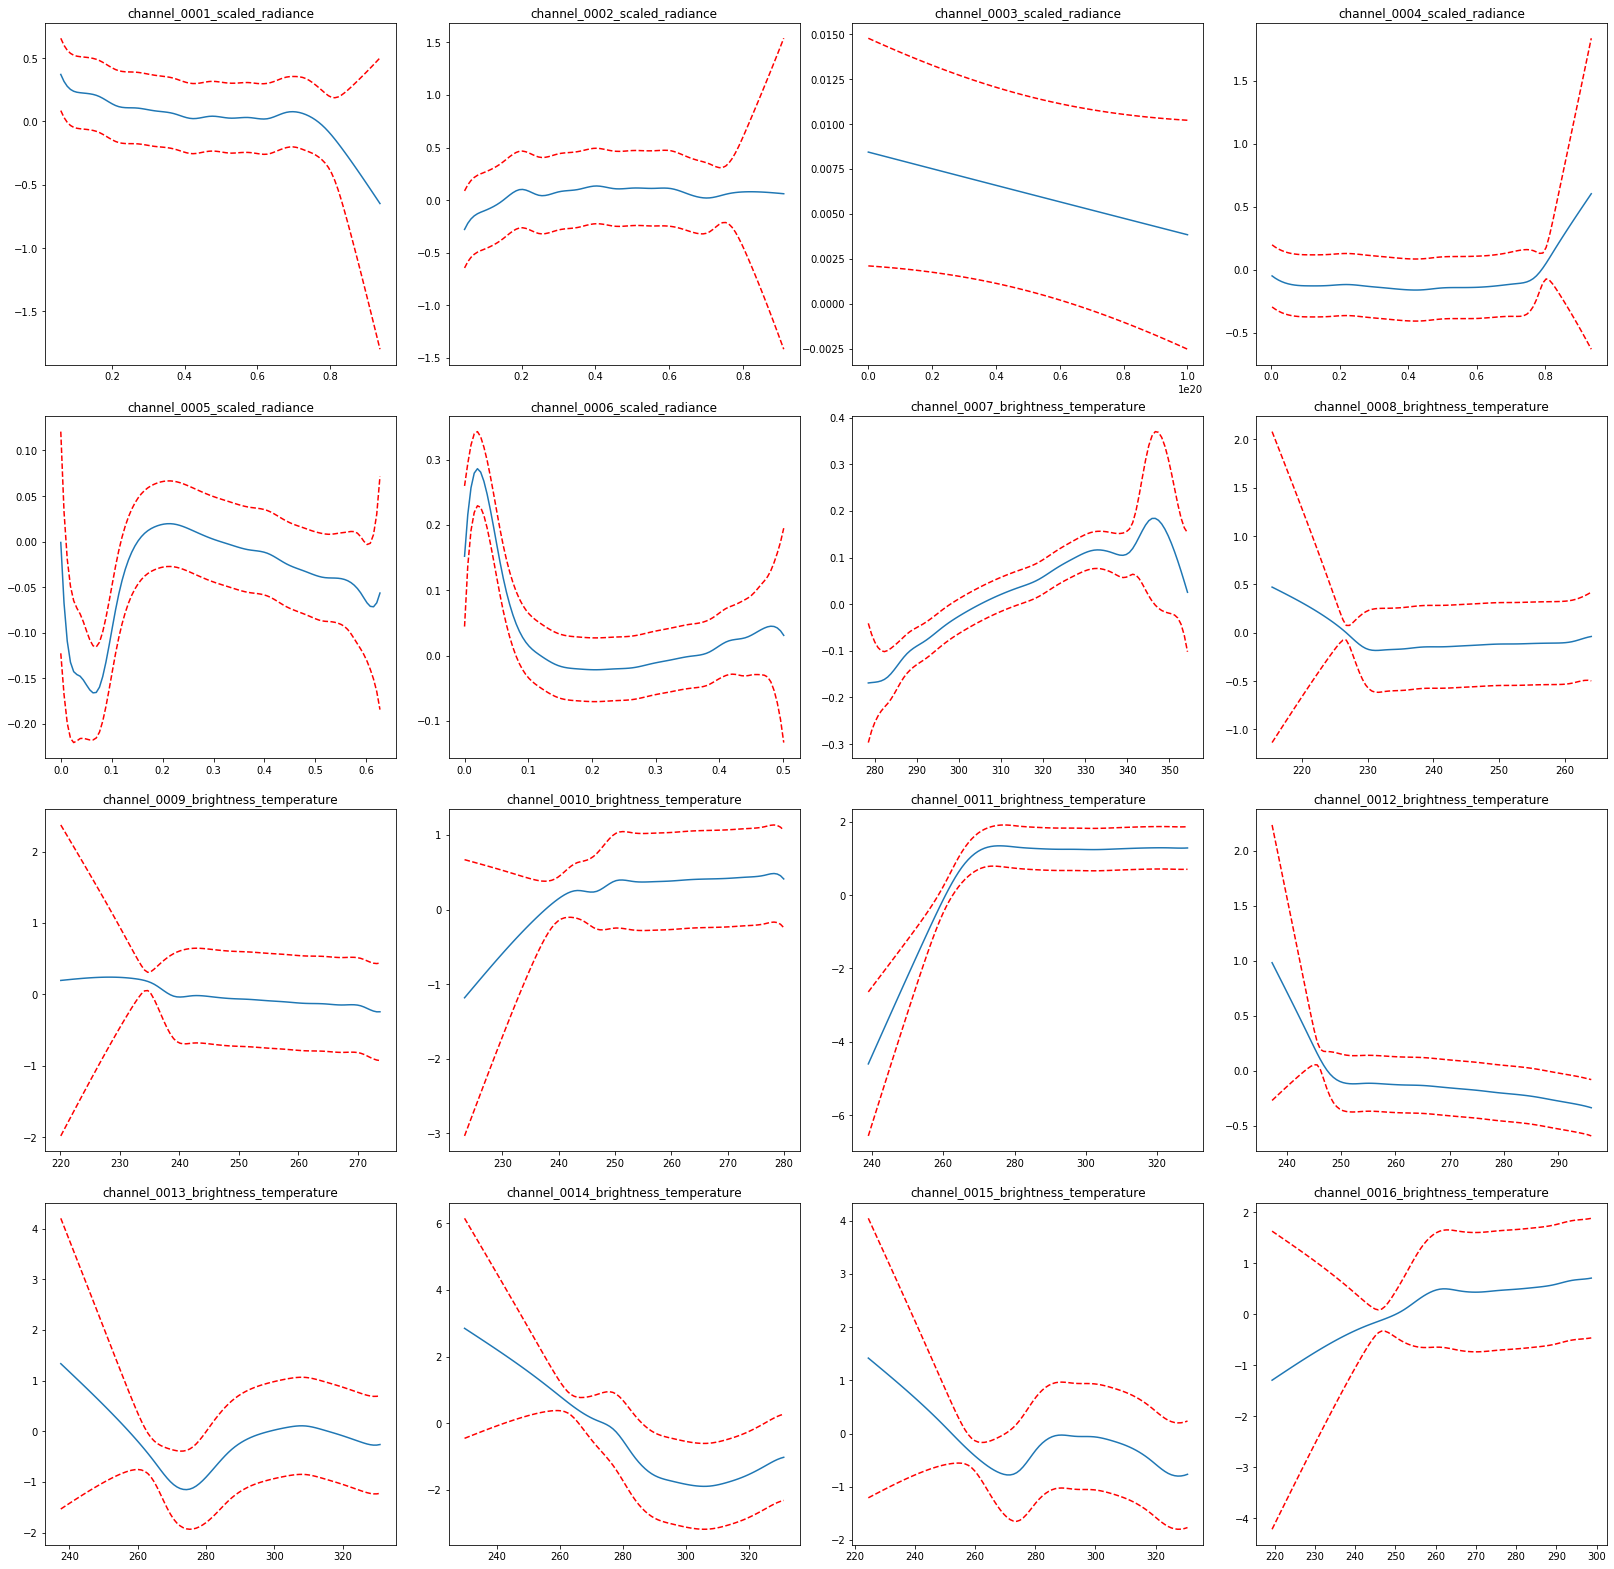


lambda_: 0.1


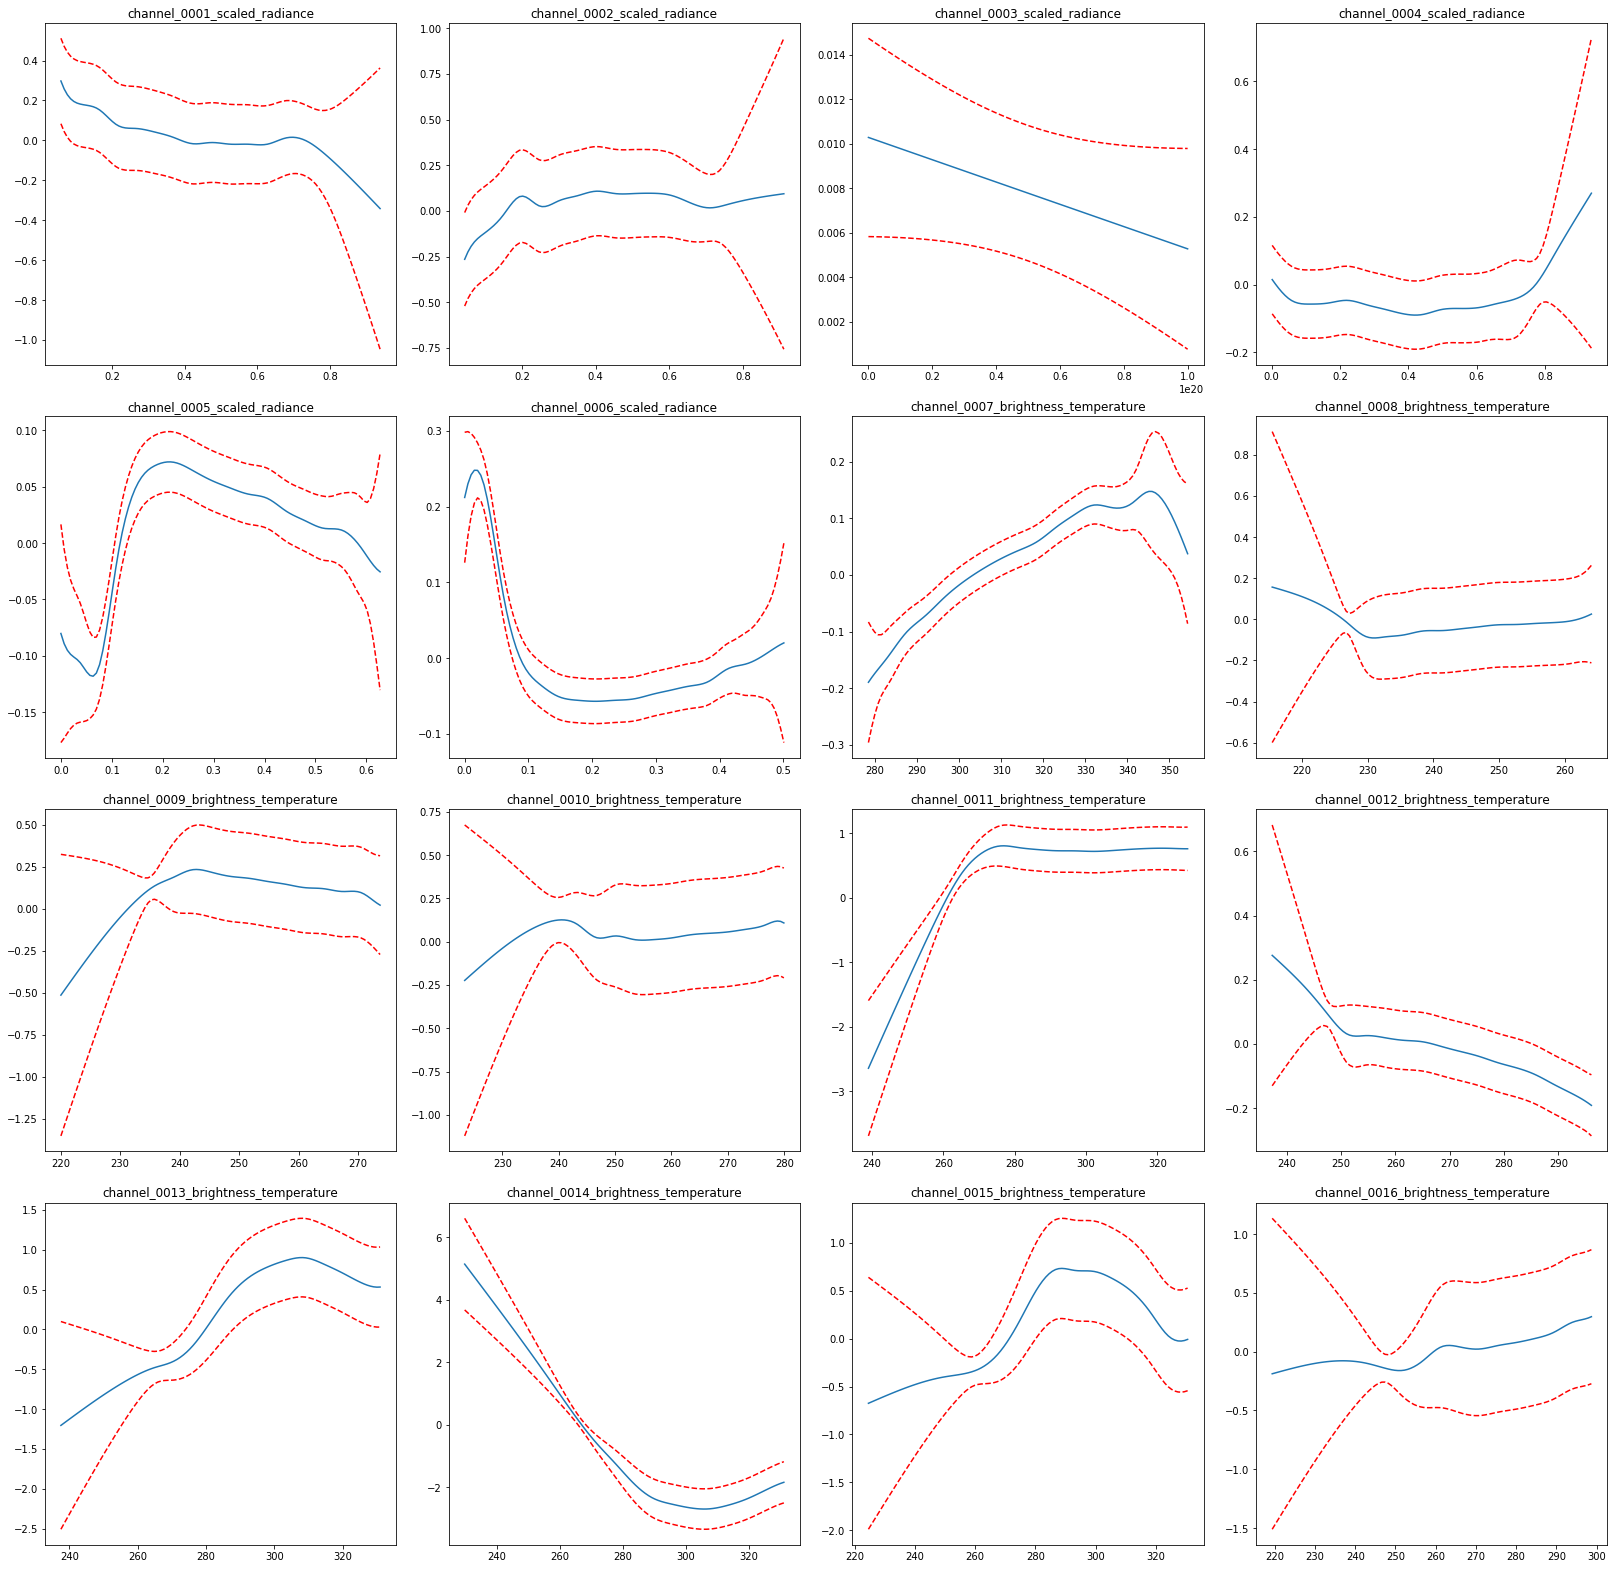


lambda_: 1


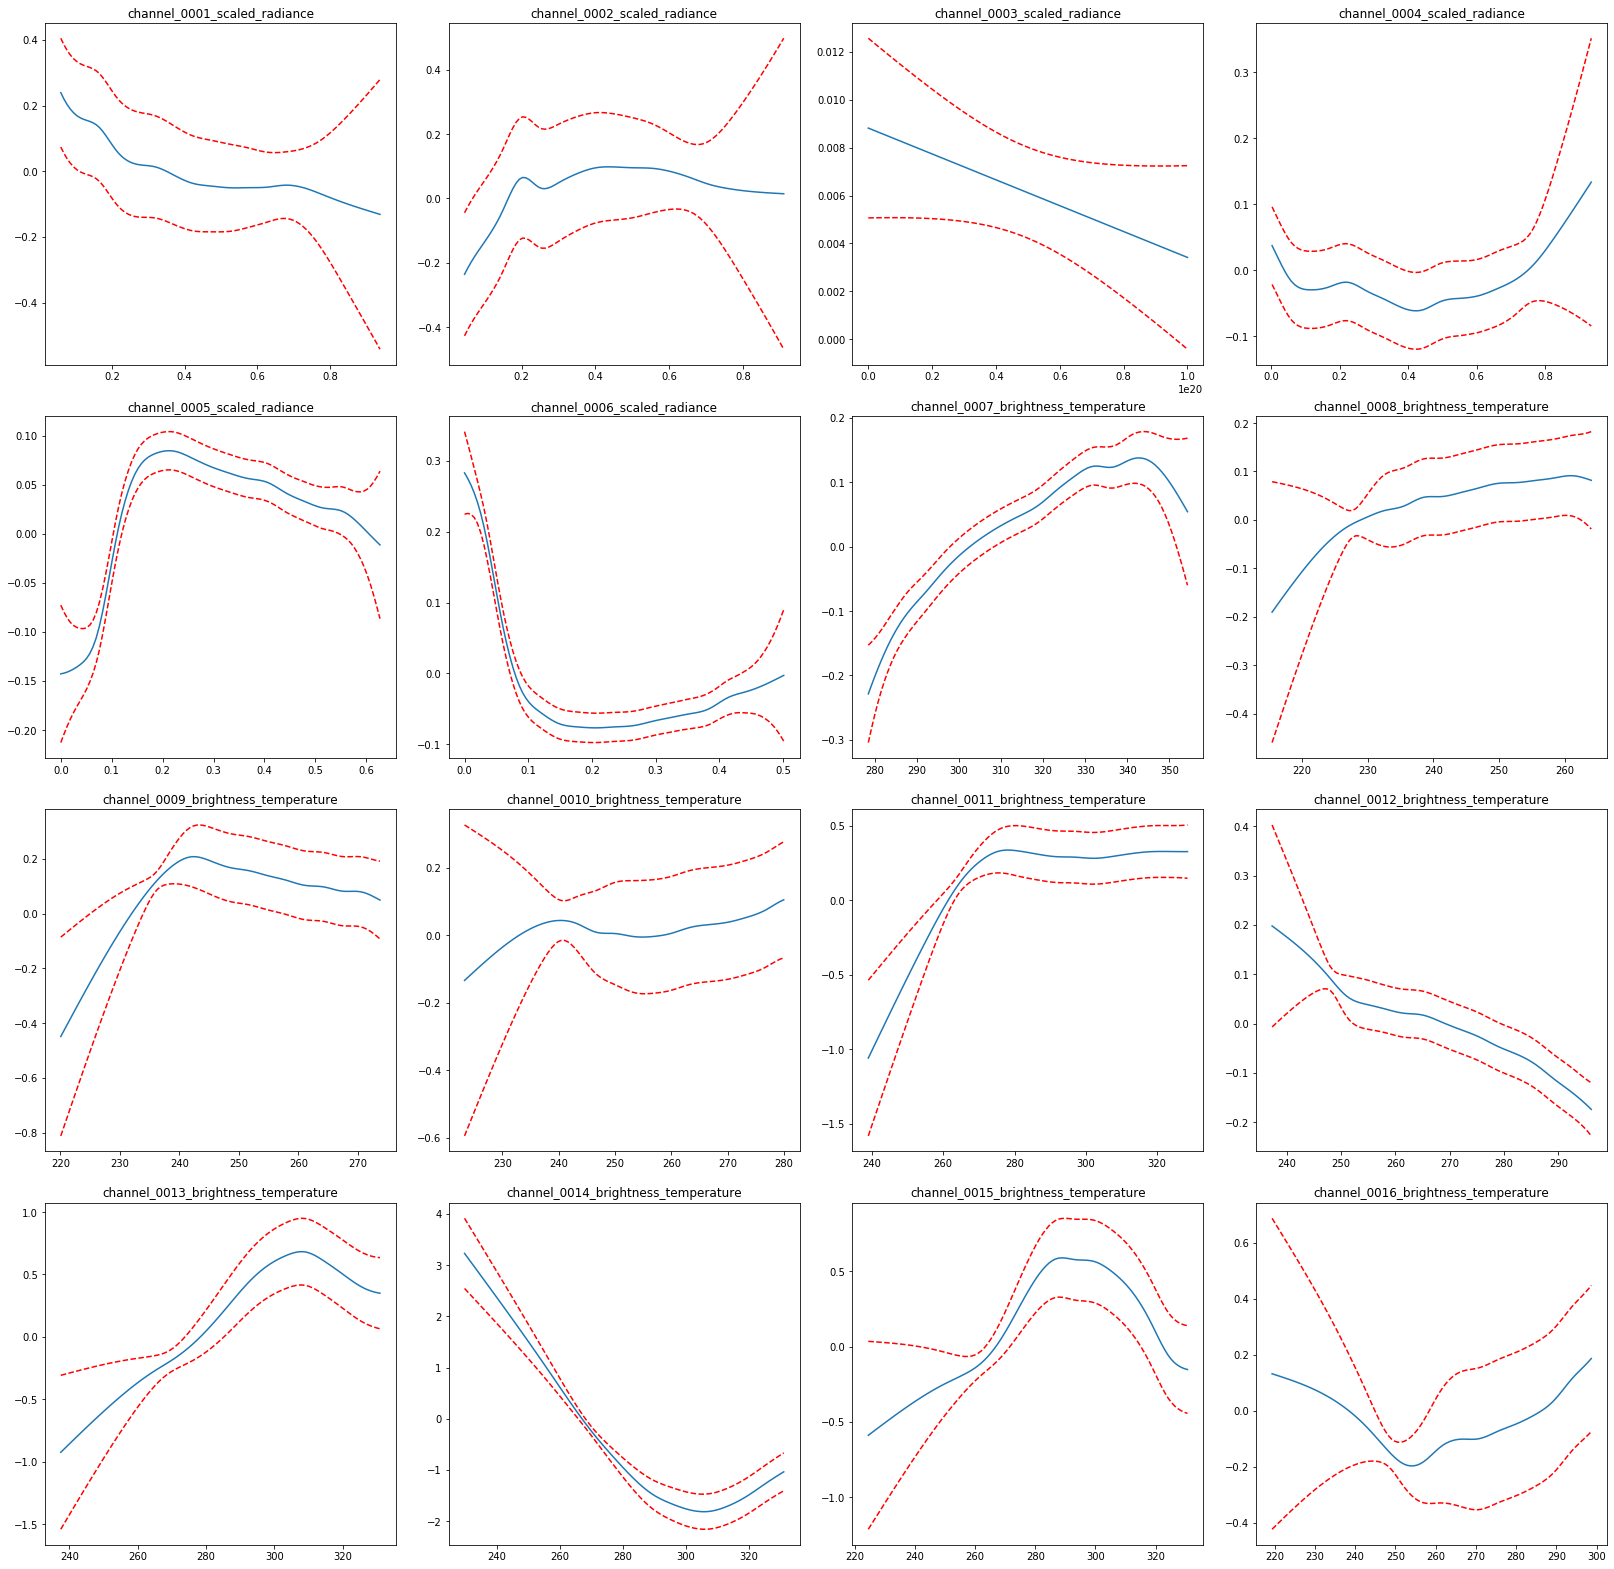


lambda_: 10


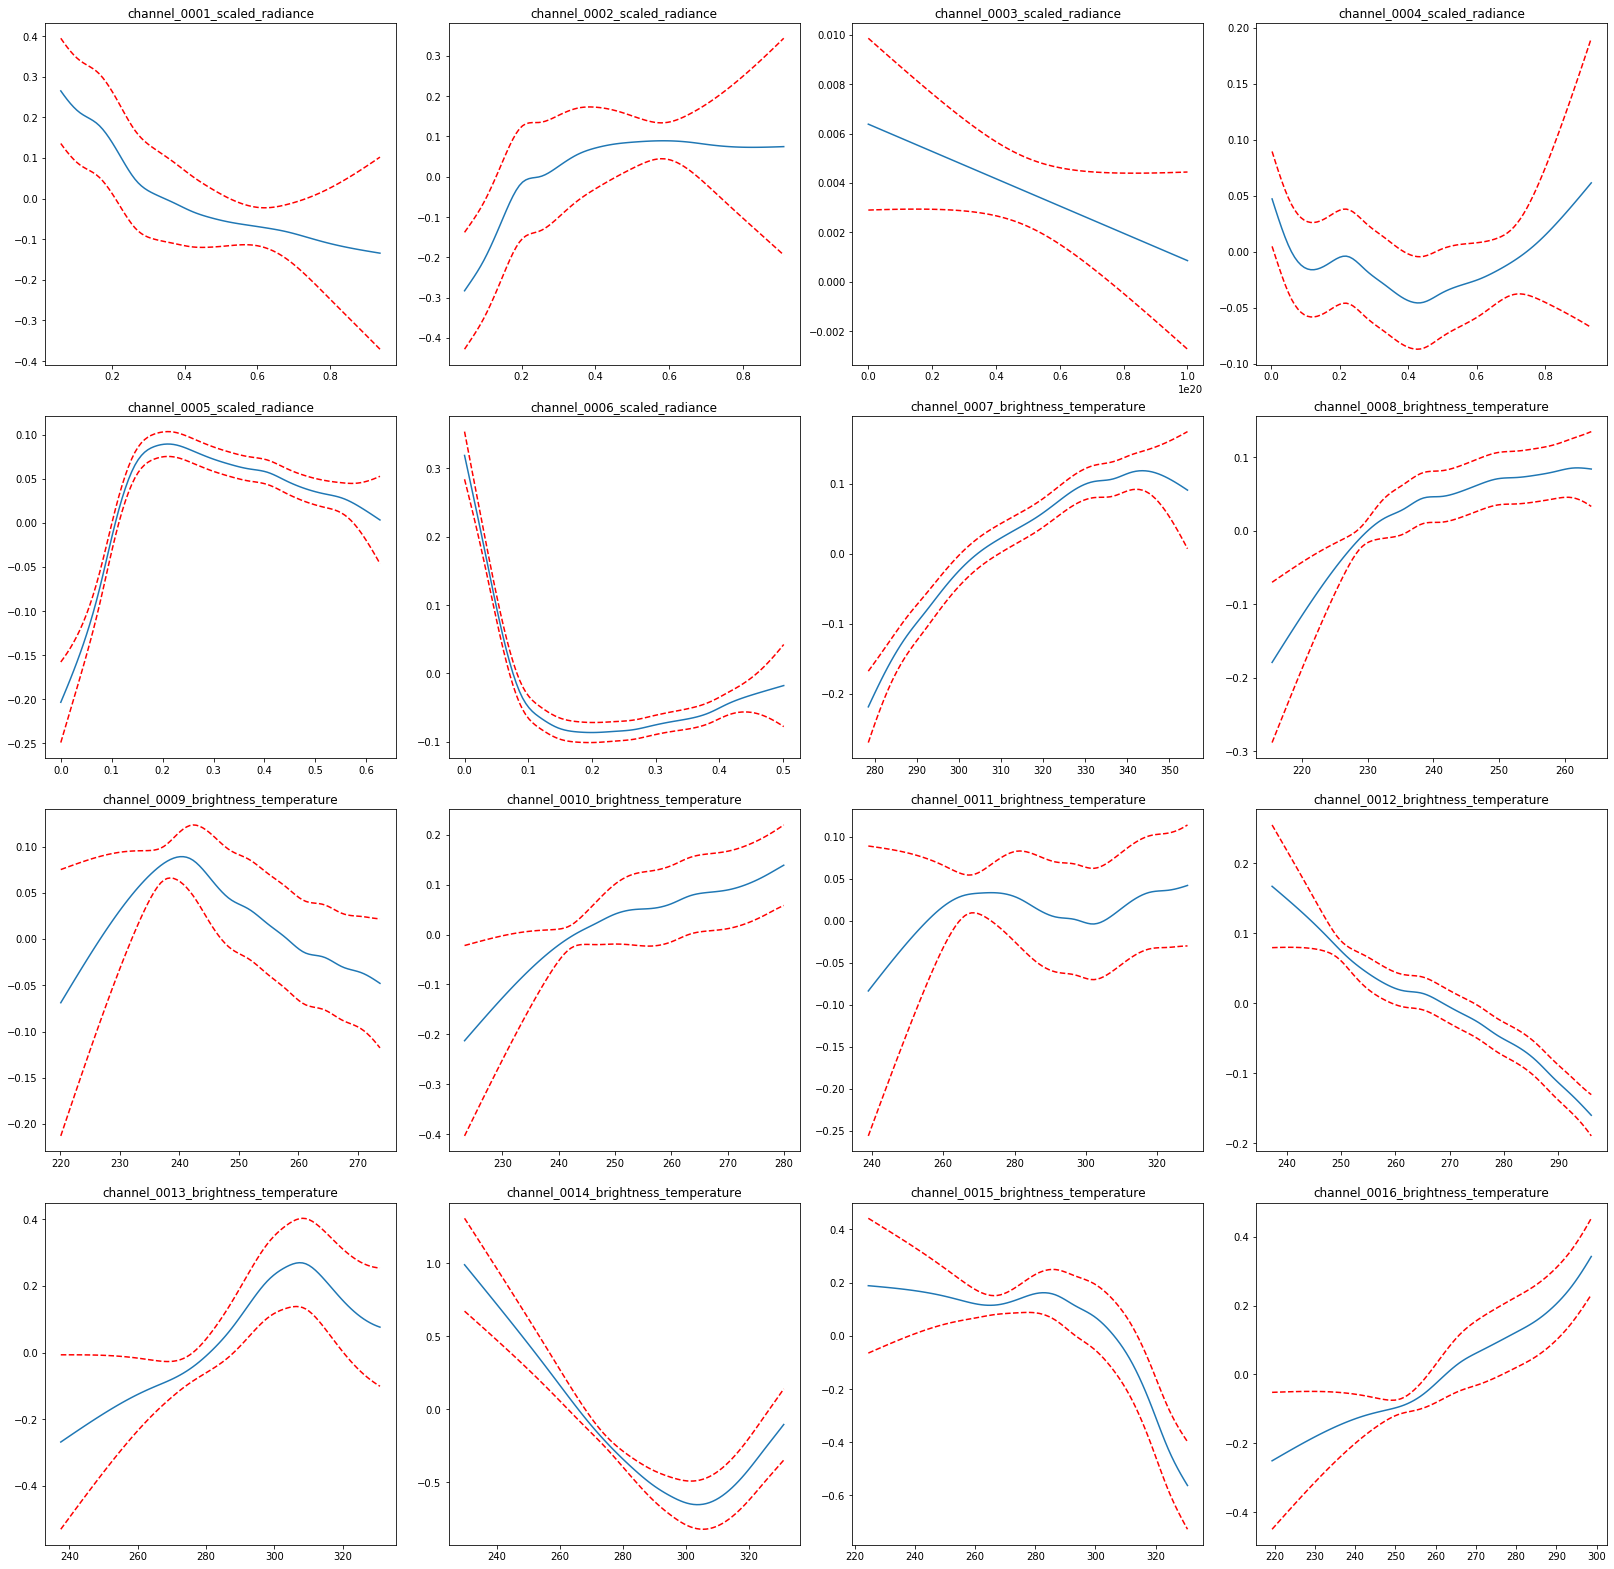


lambda_: 100


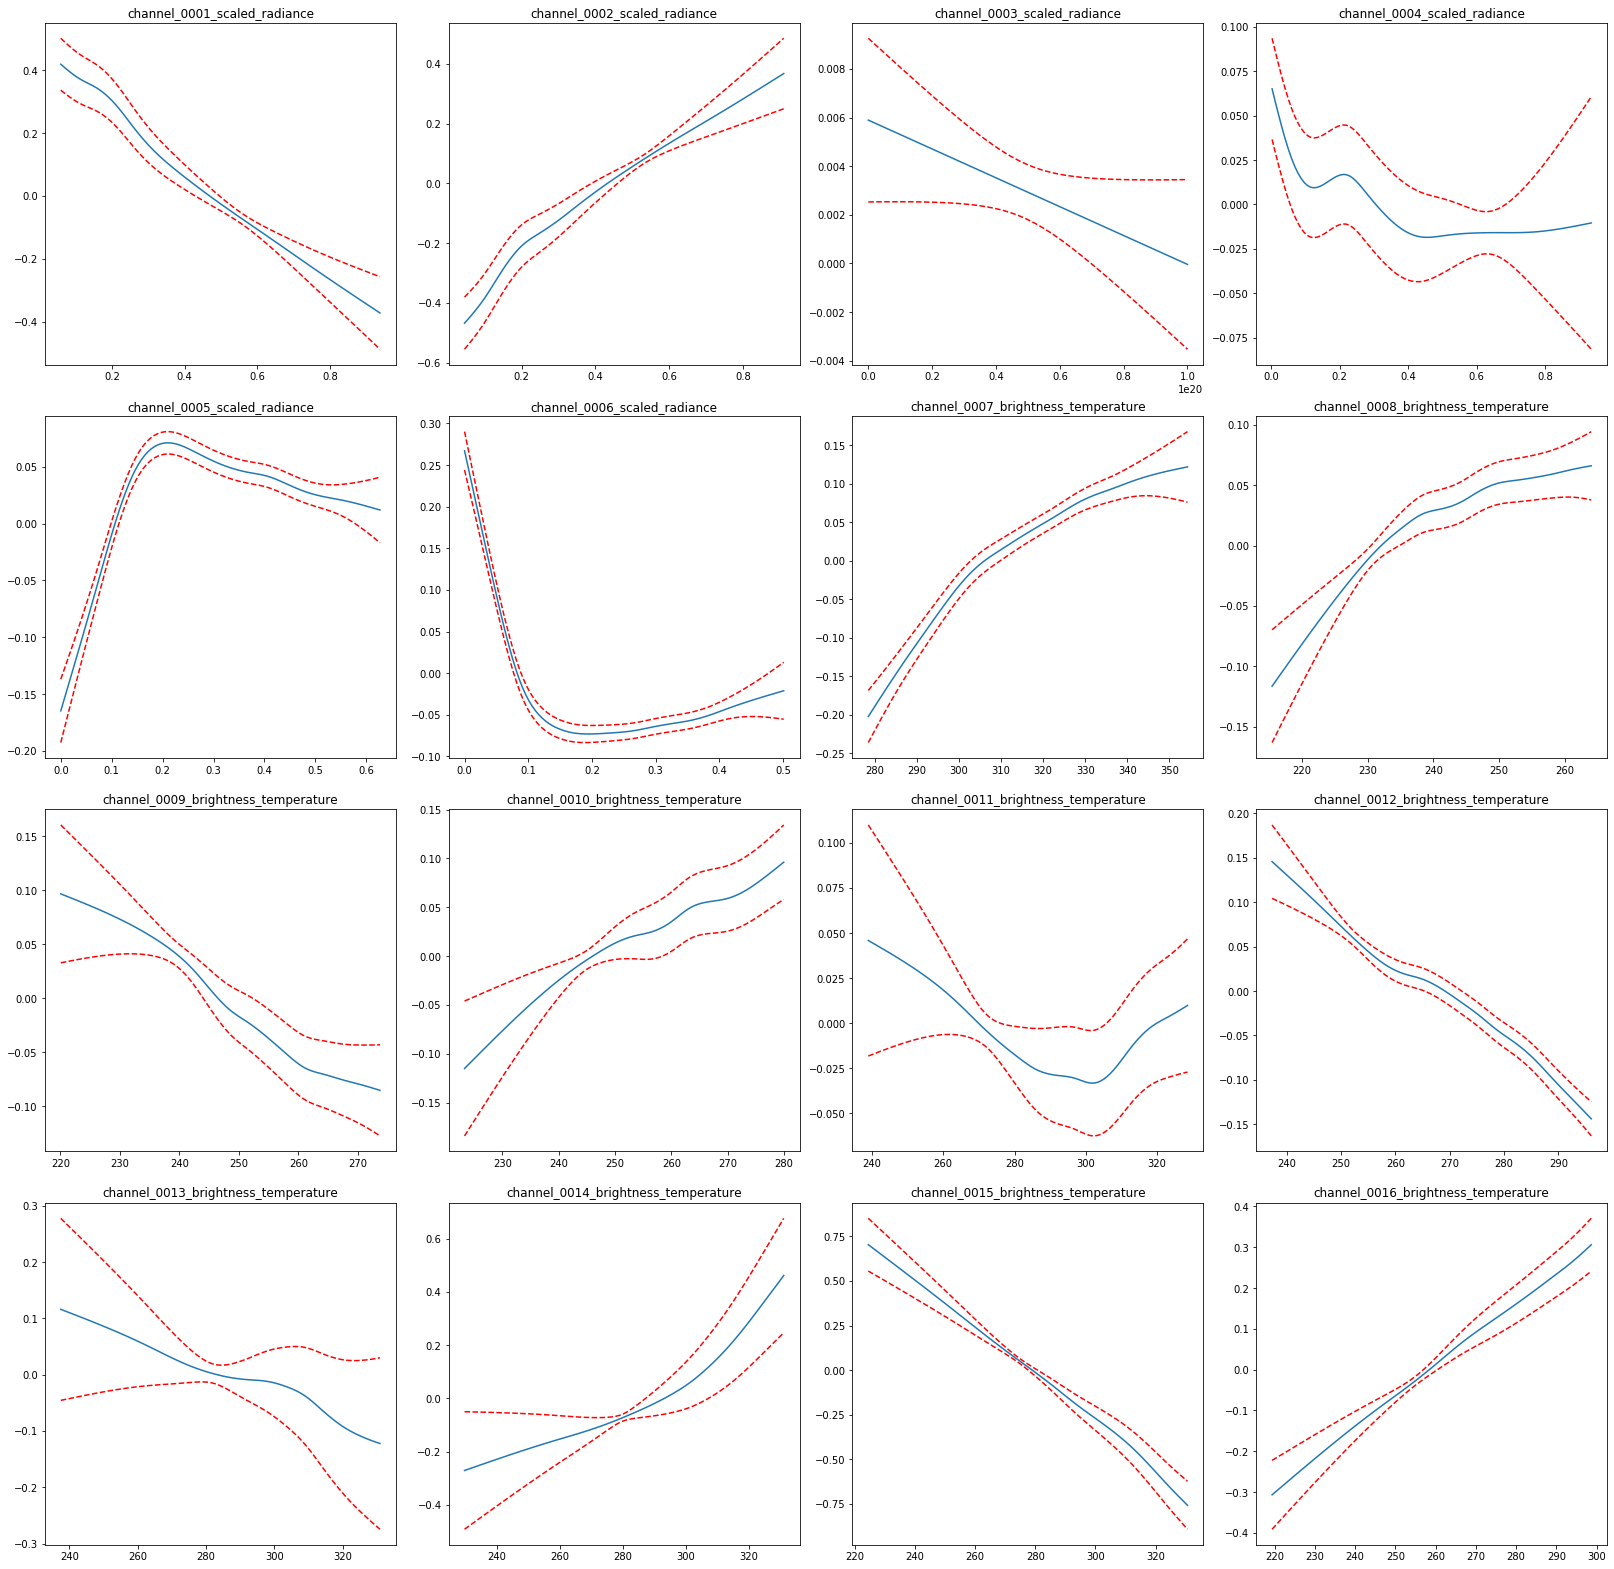

In [22]:
import matplotlib.pyplot as plt
lambda_list = [0.01, 0.1, 1, 10, 100]
for lambda_ in lambda_list:
    constraints = None
    gam_lam = LinearGAM(constraints=constraints, 
                    lam=lambda_).fit(X_train, y_train)
    print(f'\nlambda_: {lambda_}')
   
    
    fig = plt.figure(figsize=(28,28))
    titles = feature
    for i, term in enumerate(gam_lam.terms):
        if term.isintercept:
            continue

        XX = gam_lam.generate_X_grid(term=i)
        pdep, confi = gam_lam.partial_dependence(term=i, X=XX, width=0.95)

        ax = plt.subplot(4, 4, i+1)
        plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.15,hspace=0.15)
        ax.plot(XX[:, i], pdep)
        ax.plot(XX[:, i], confi, c='r', ls='--')
        ax.set_title(titles[i])
    plt.show()

## 2.2 test nsplines


lambda_: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


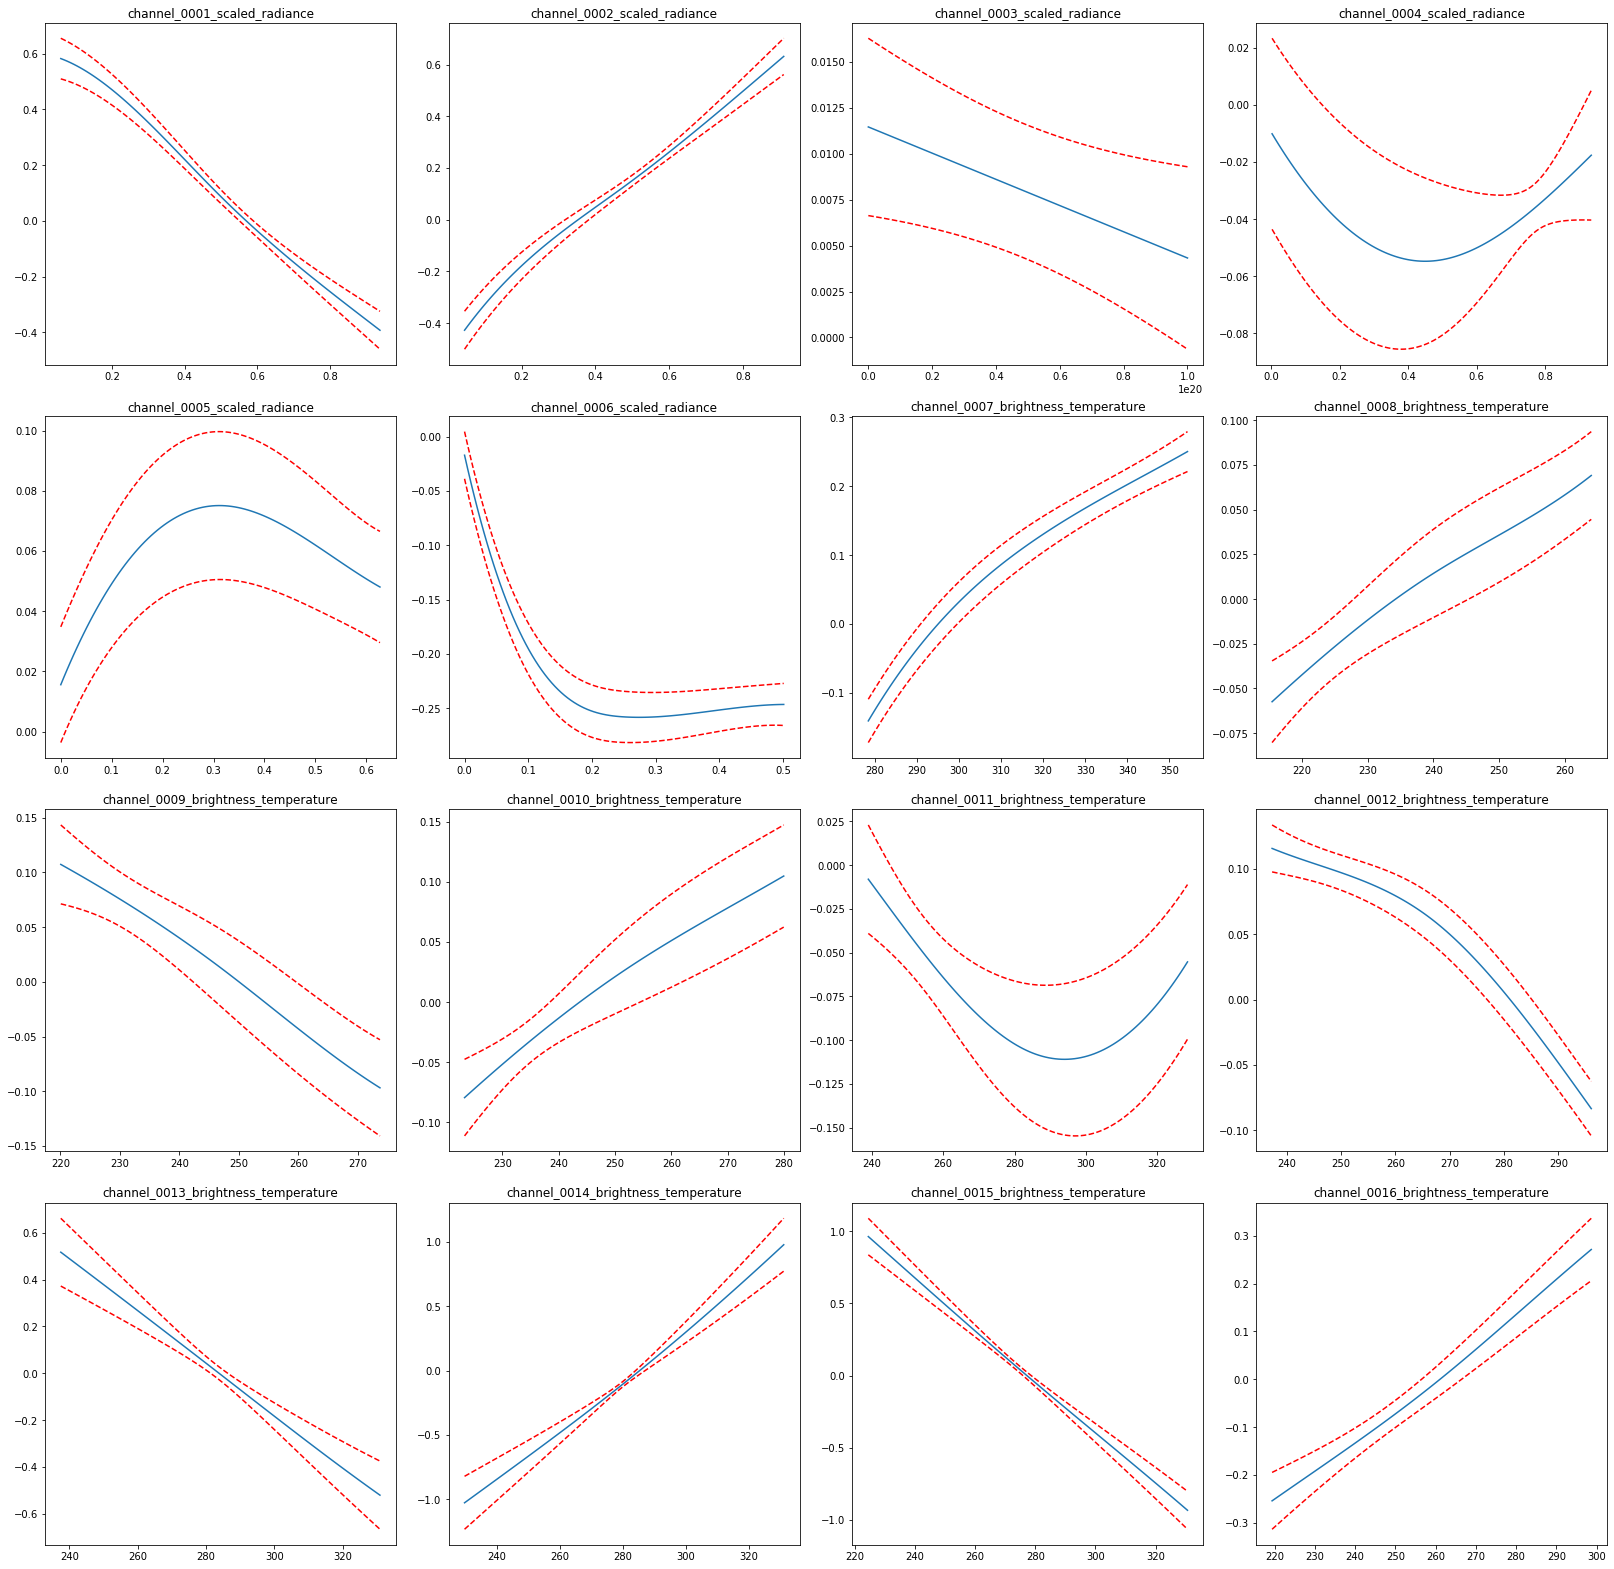


lambda_: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


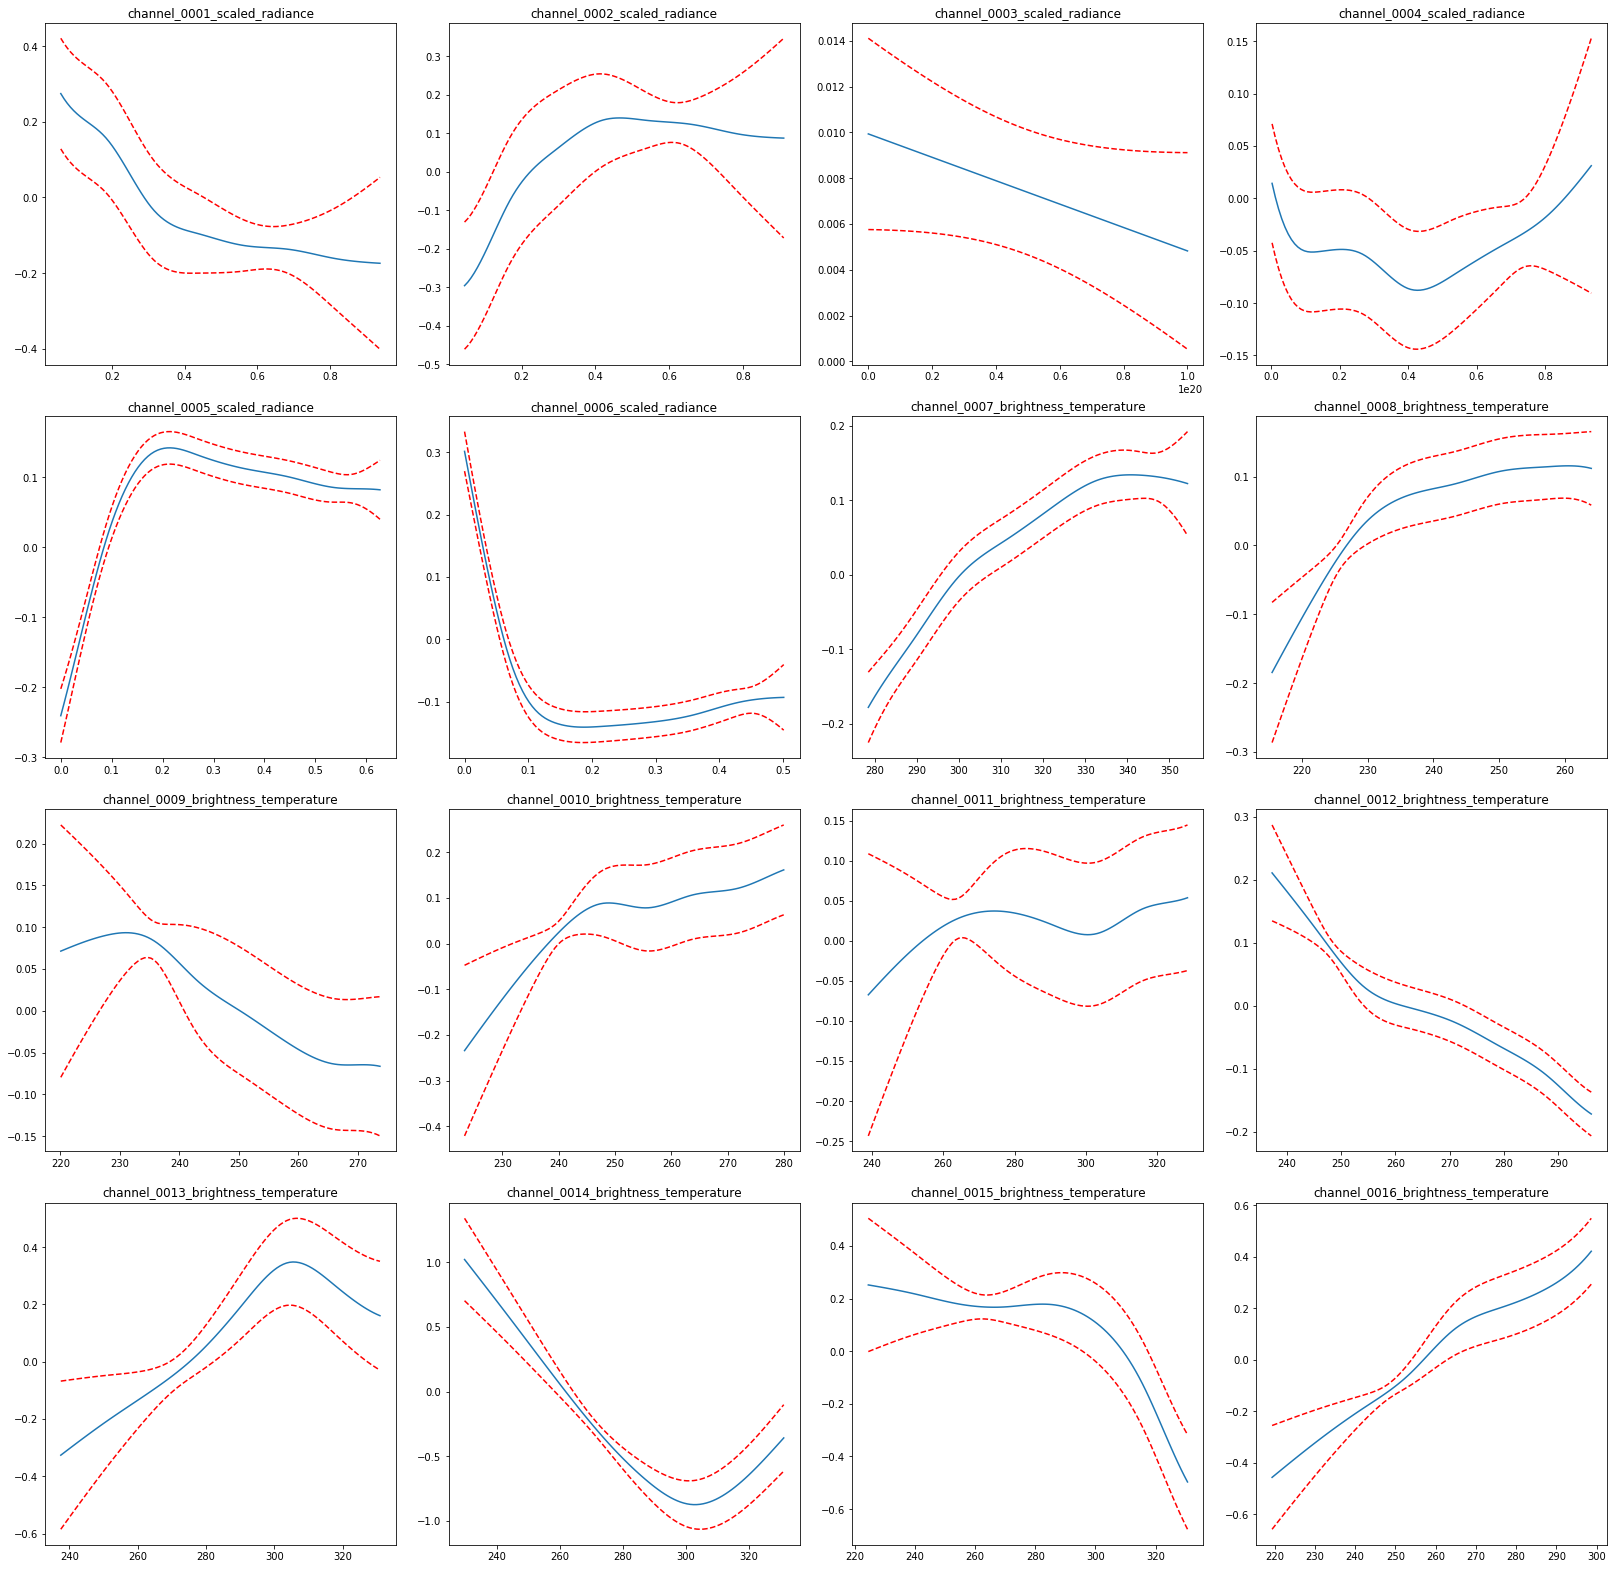


lambda_: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


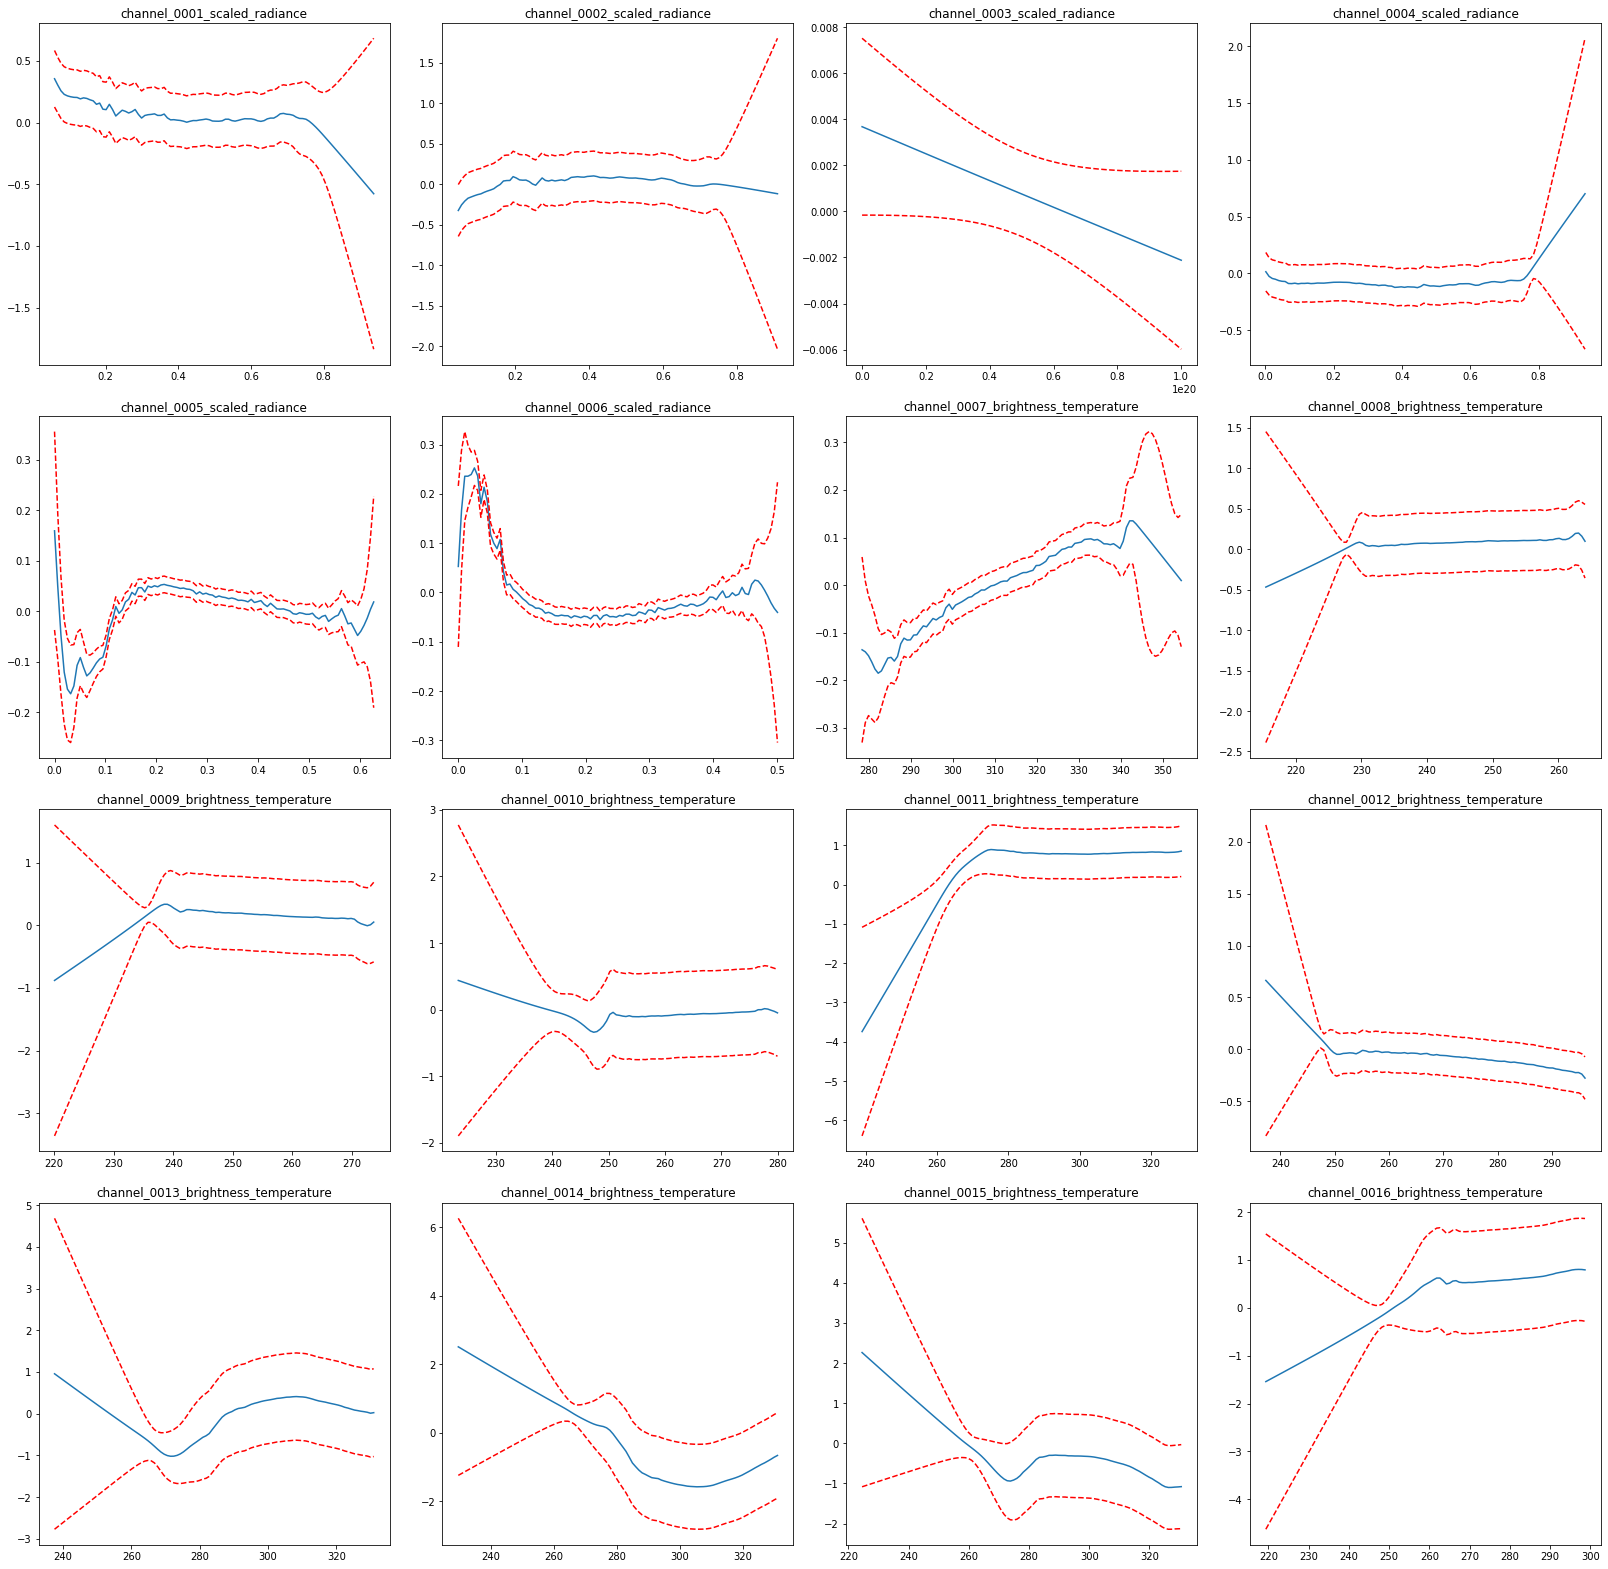

In [26]:
n_splines_list = [[5]*16, [10]*16, [100]*16]
for n_splines in n_splines_list:
    constraints = None
    gam_nsplines = LinearGAM(constraints = constraints, 
                    n_splines = n_splines).fit(X_train, y_train)
    print(f'\nlambda_: {n_splines}')
    
           
    fig = plt.figure(figsize=(28,28))
    titles = feature
    for i, term in enumerate(gam_nsplines.terms):
        if term.isintercept:
            continue

        XX = gam_nsplines.generate_X_grid(term=i)
        pdep, confi = gam_nsplines.partial_dependence(term=i, X=XX, width=0.95)

        ax = plt.subplot(4, 4, i+1)
        plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.15,hspace=0.15)
        ax.plot(XX[:, i], pdep)
        ax.plot(XX[:, i], confi, c='r', ls='--')
        ax.set_title(titles[i])
    plt.show()

## 2.3 test constraints


constraints: convex


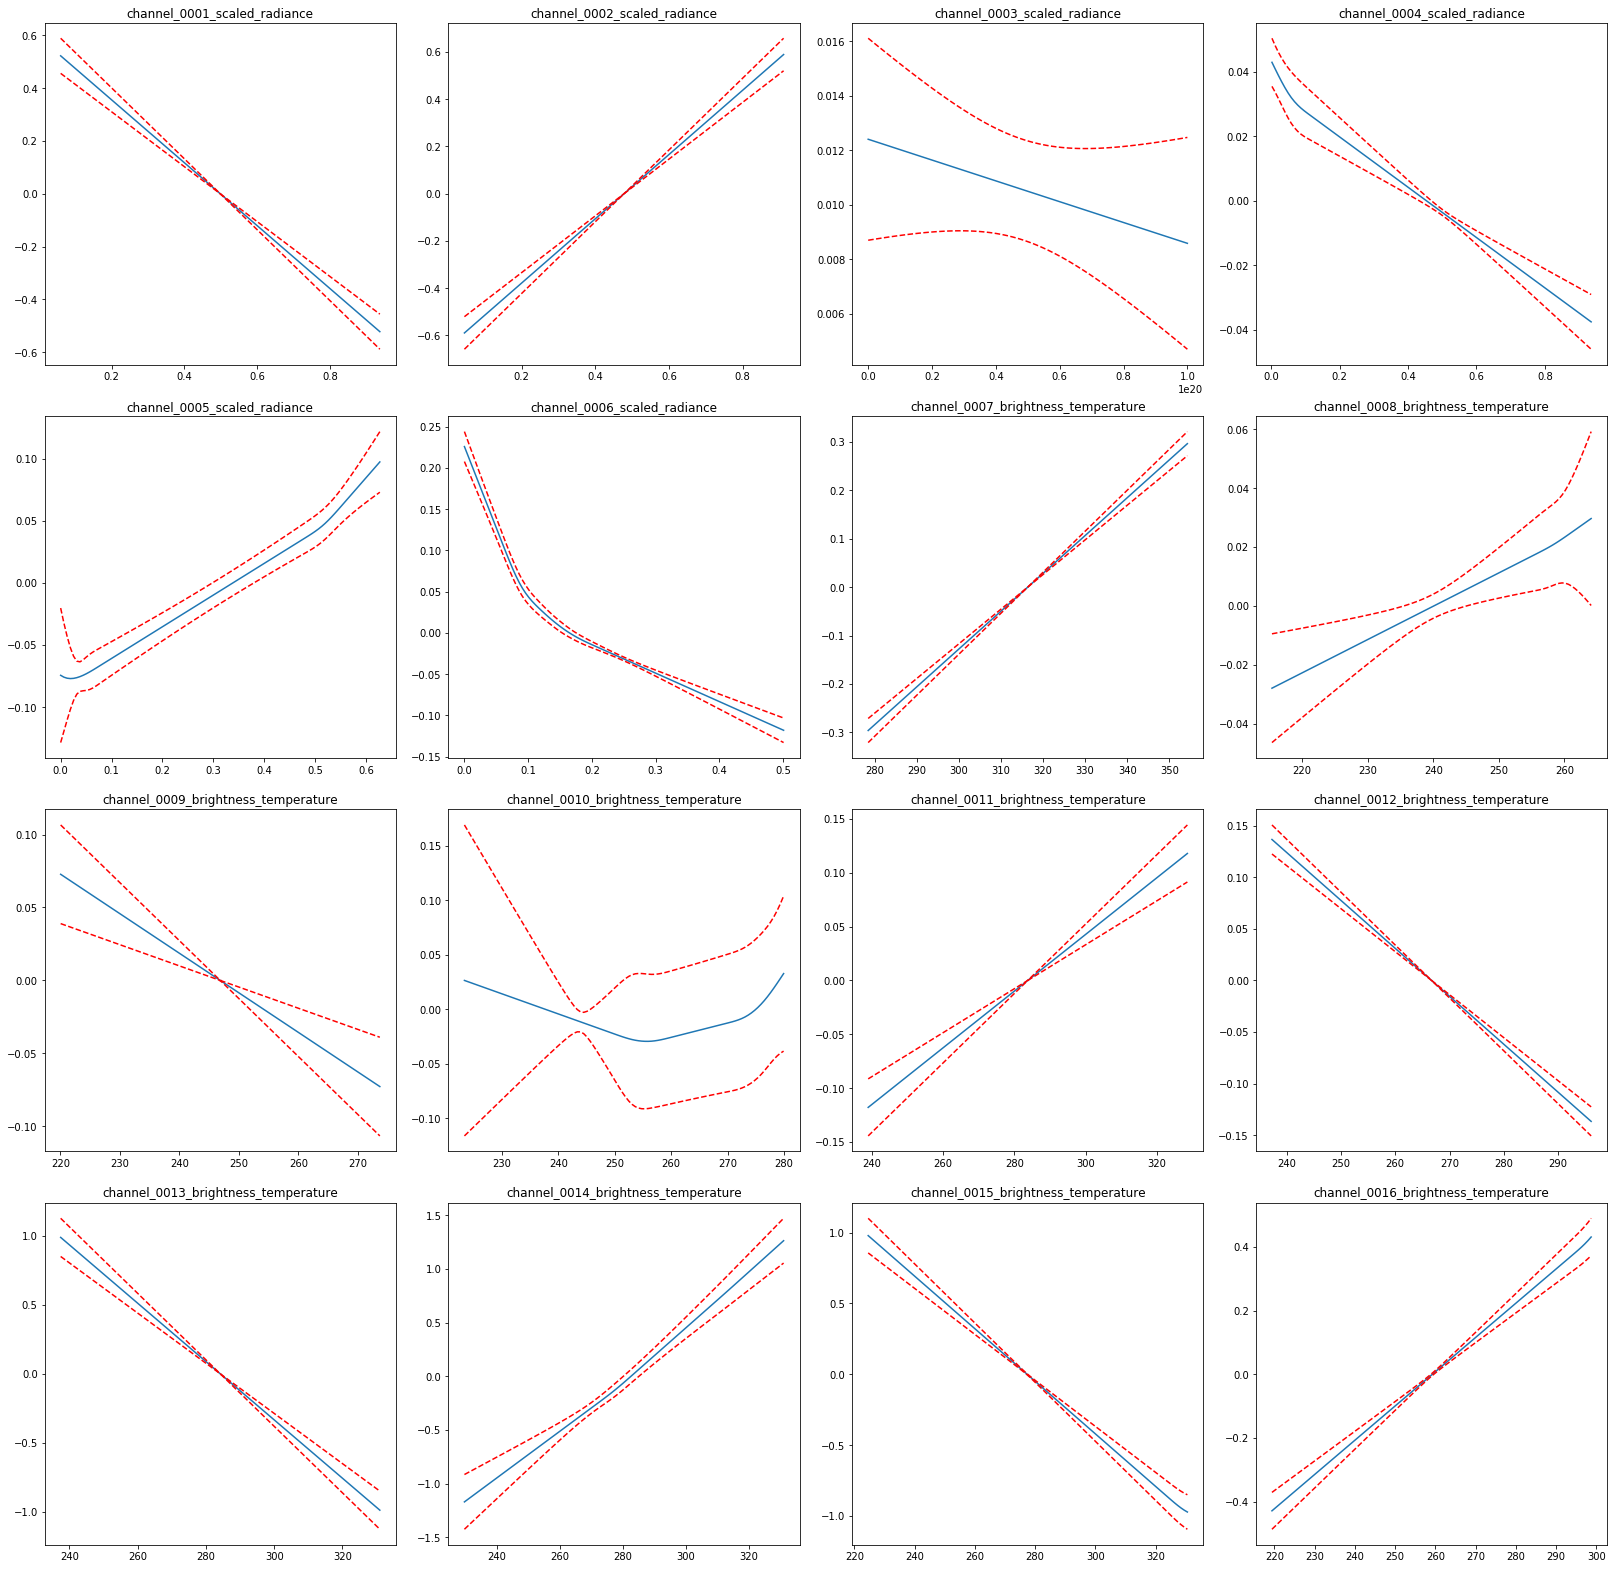


constraints: concave


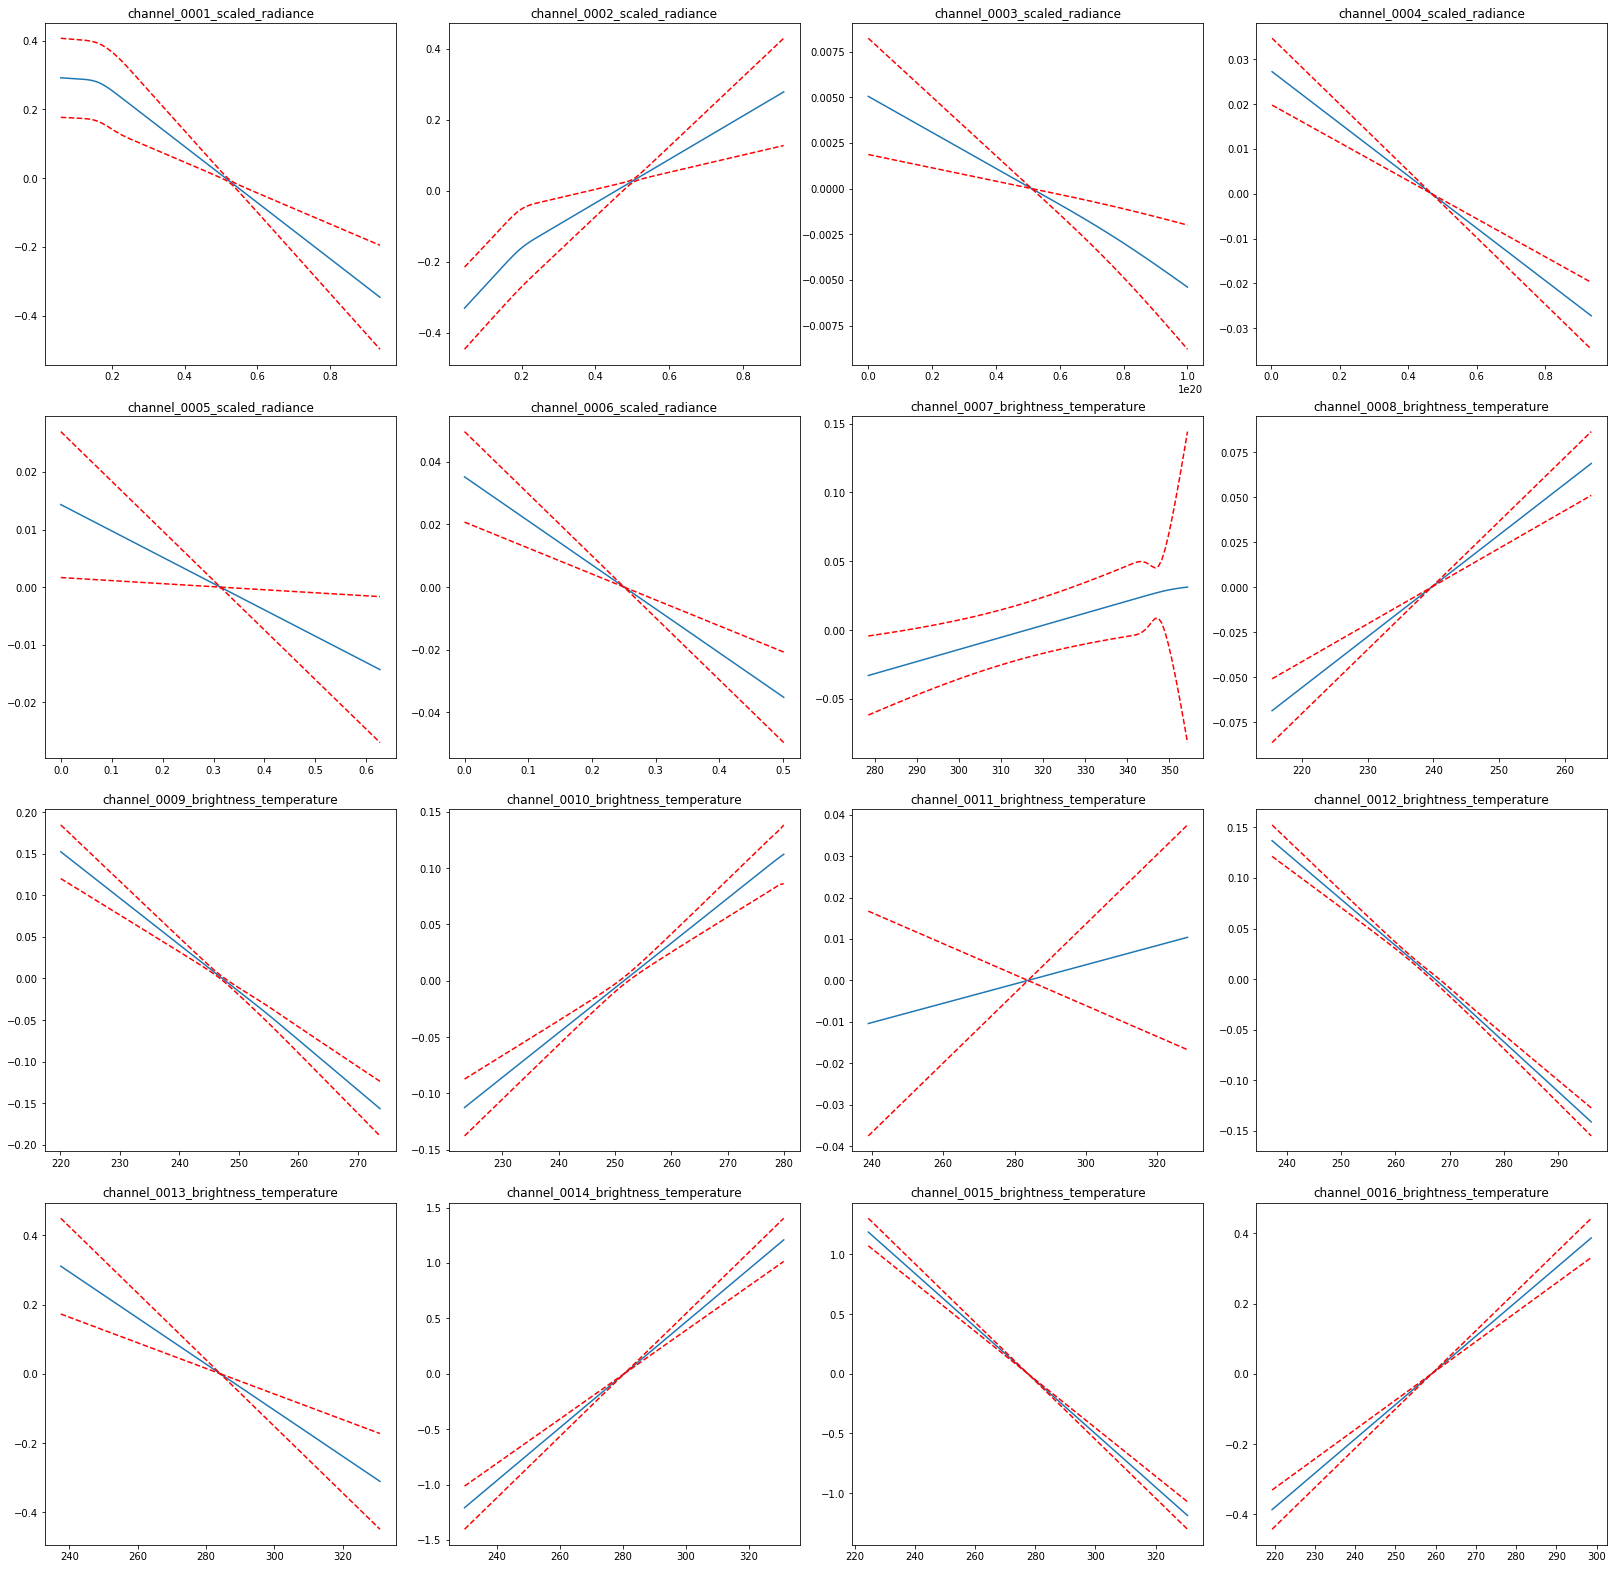


constraints: monotonic_inc


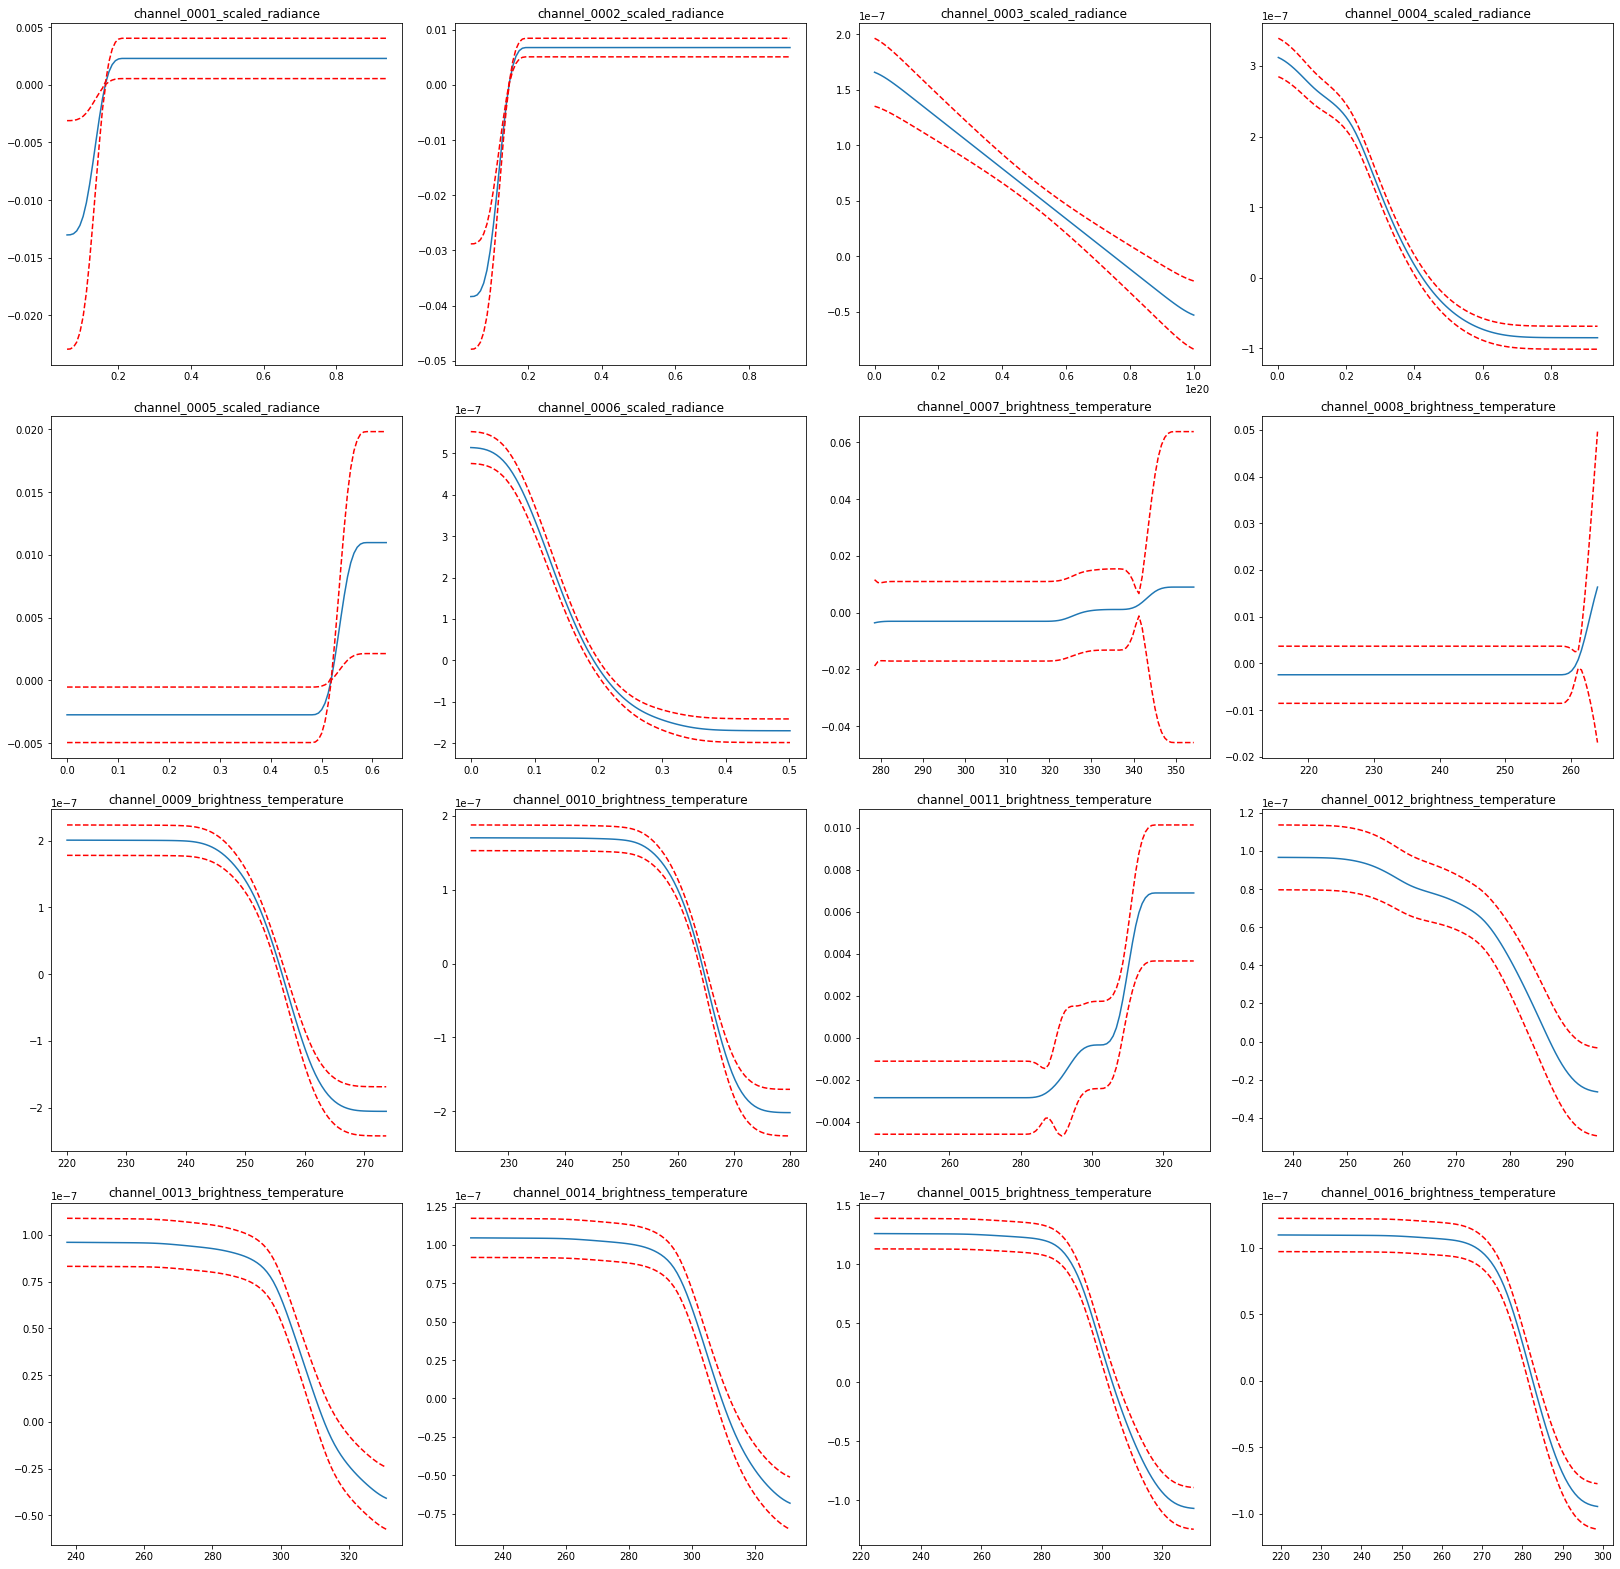


constraints: monotonic_dec


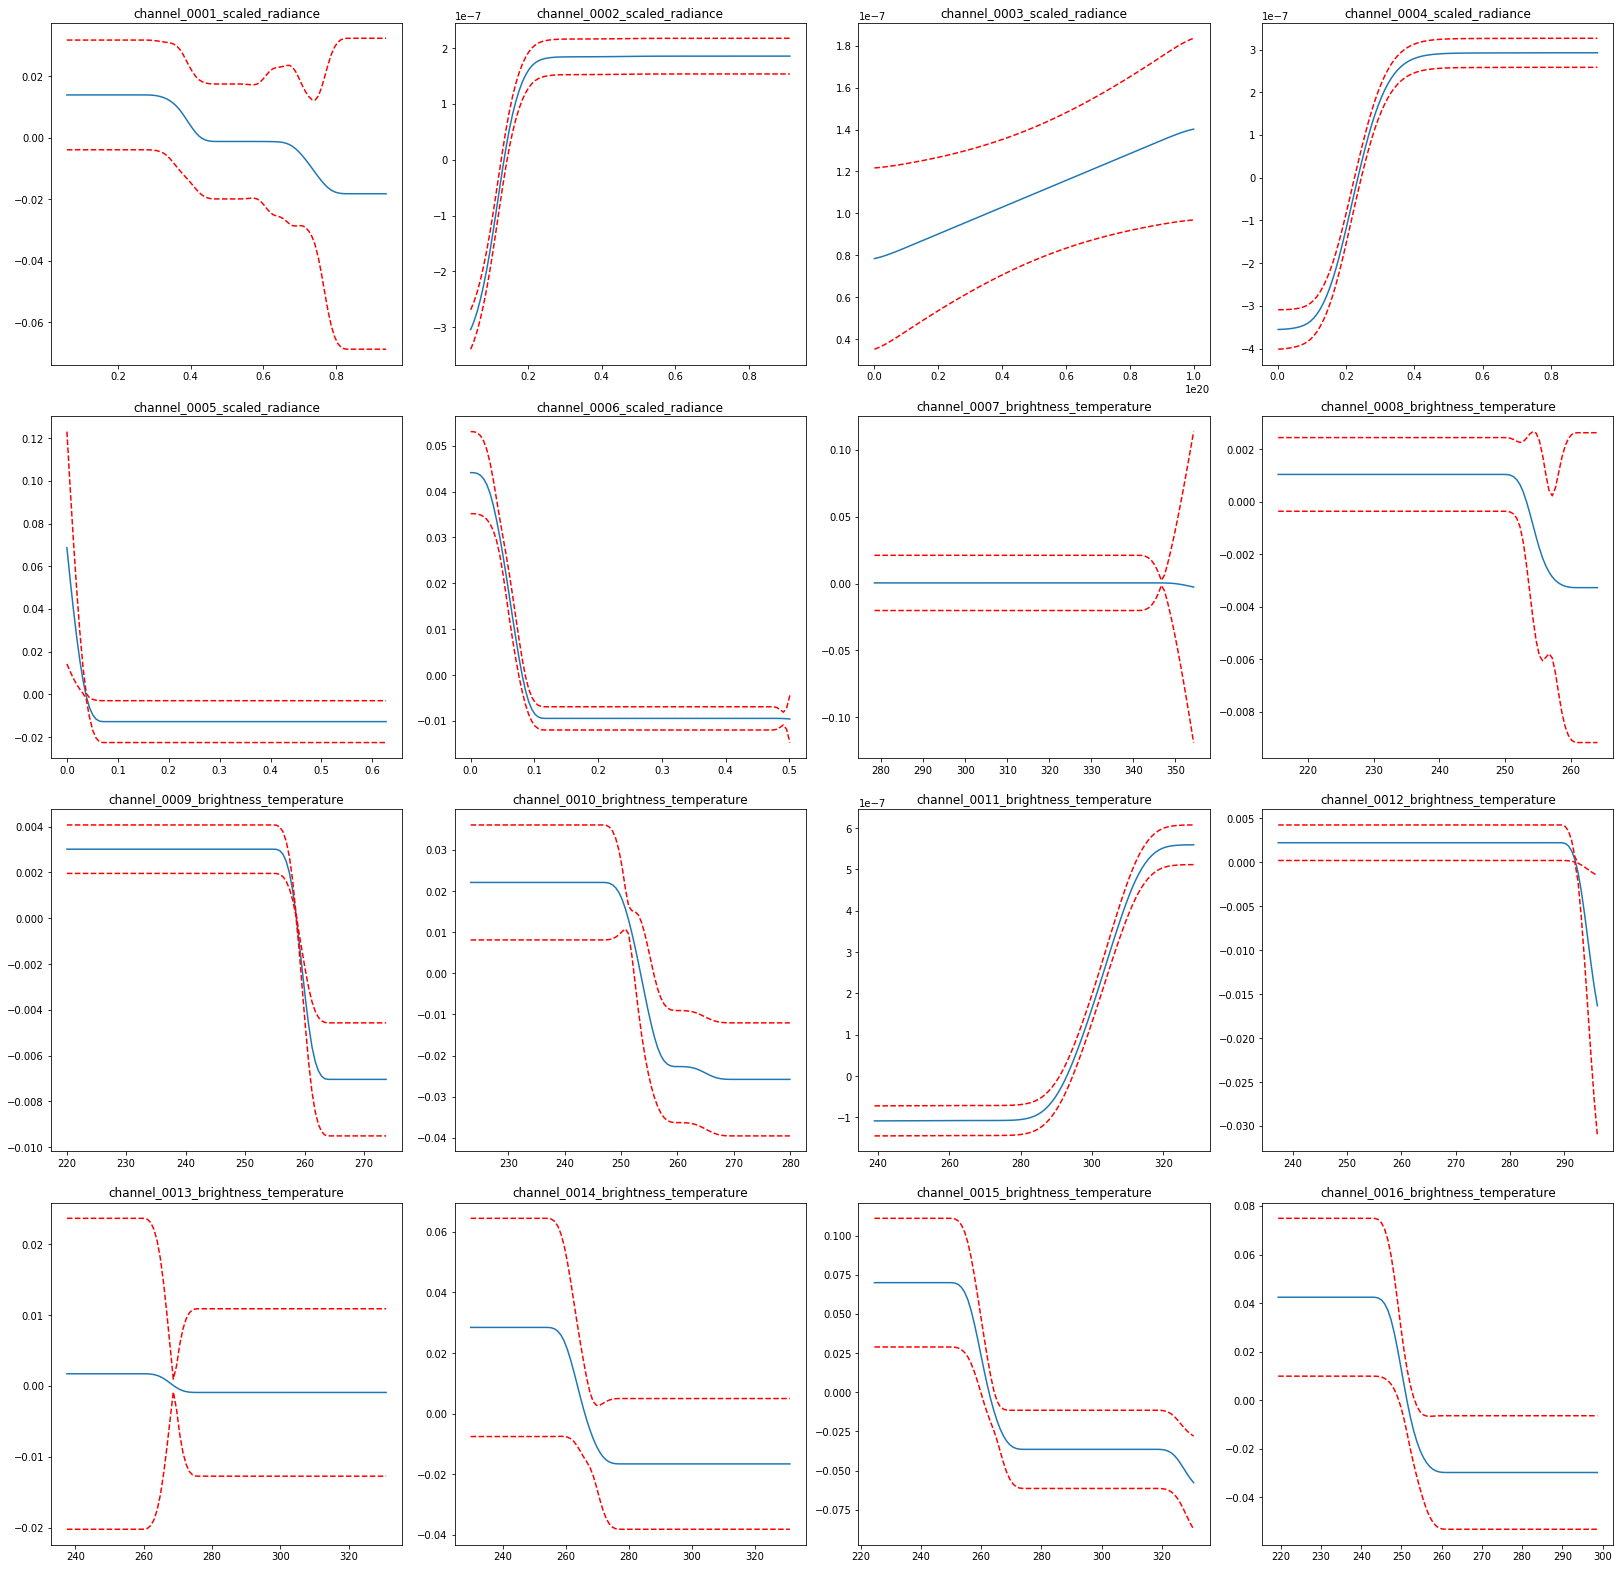


constraints: none


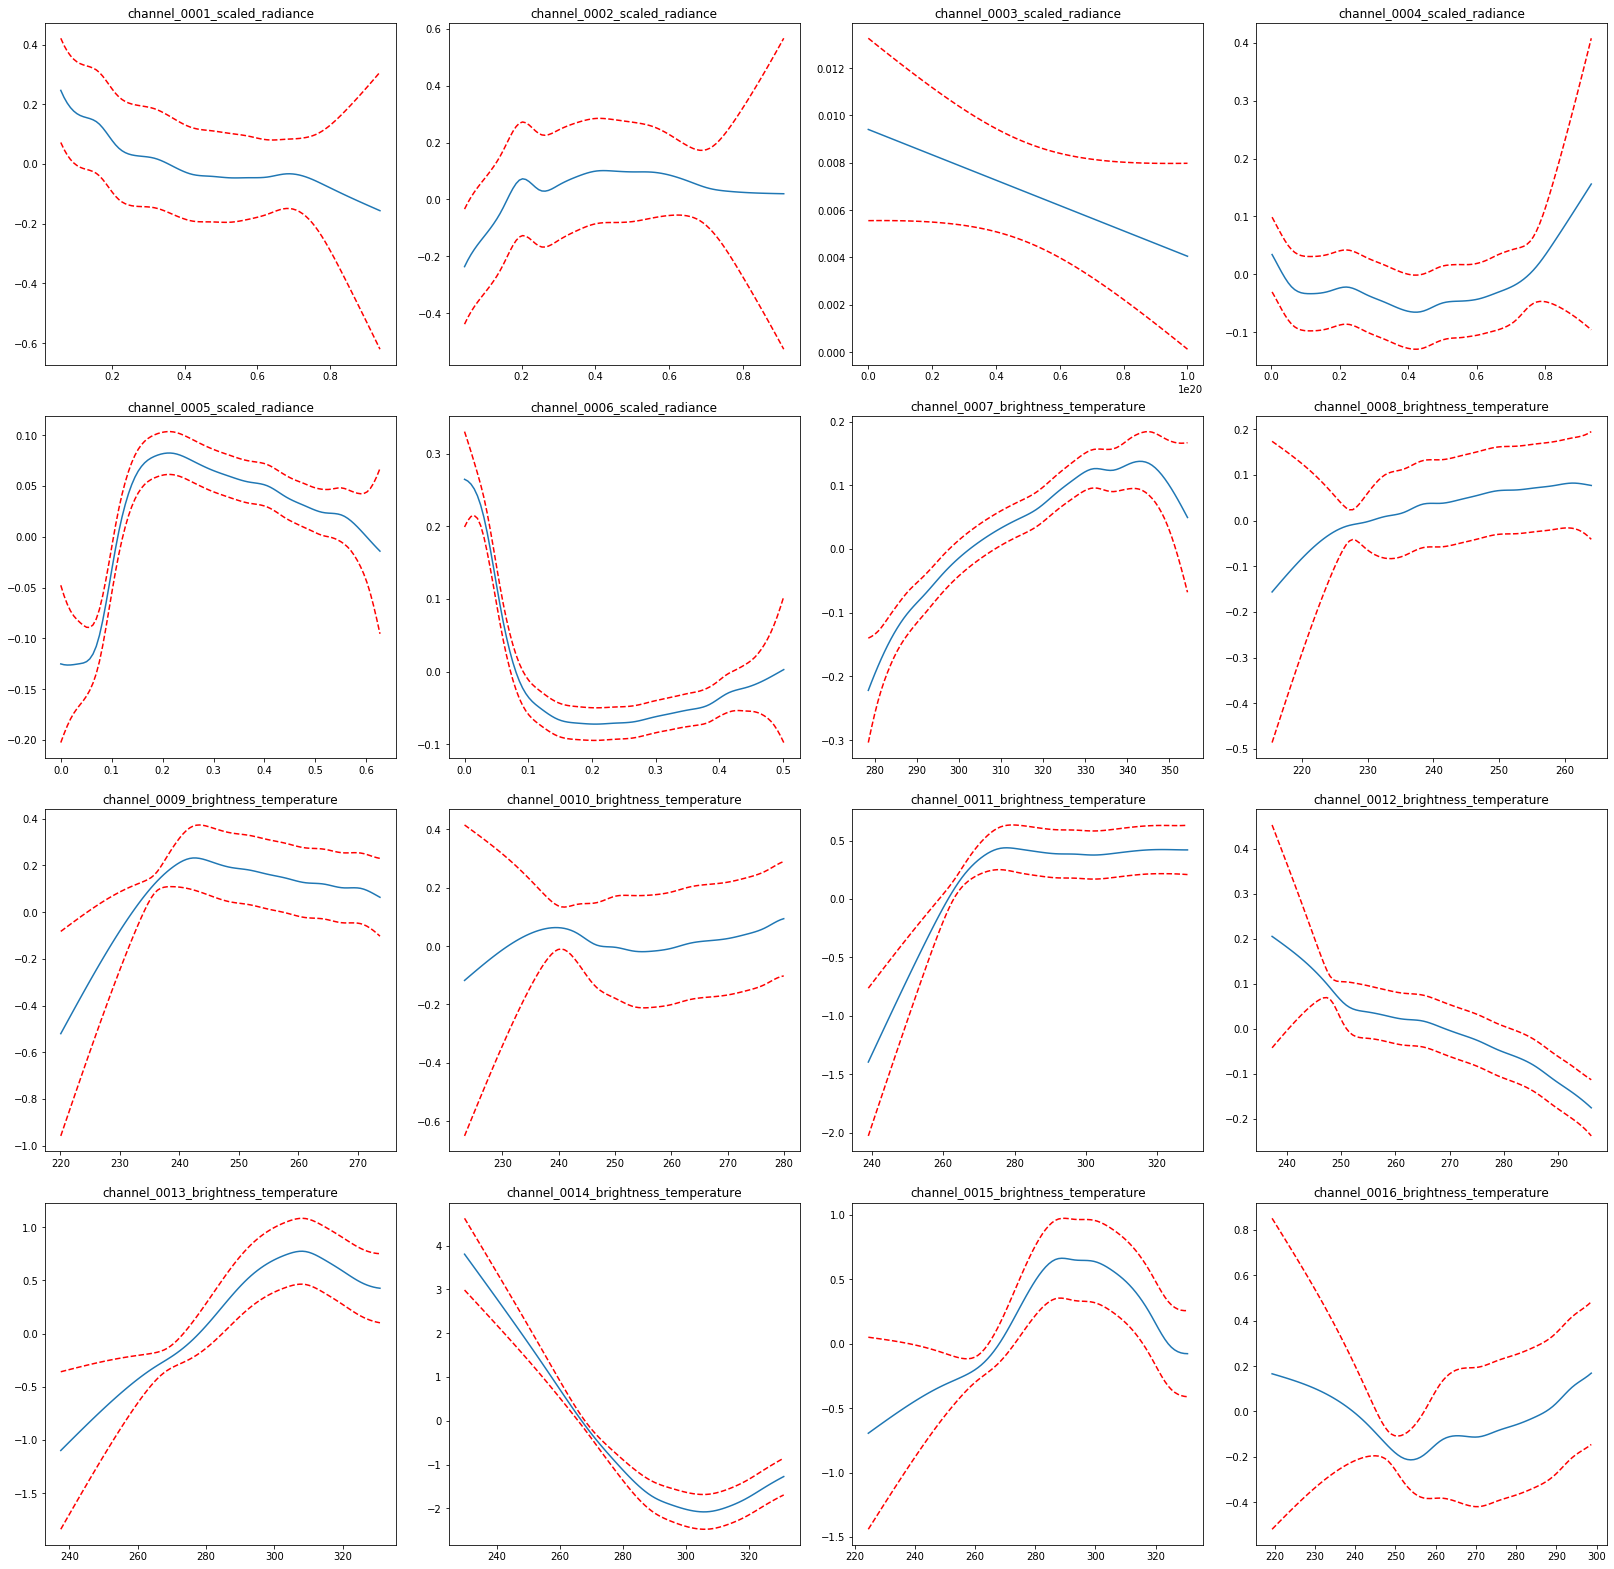

In [27]:
constraints_list = ['convex', 'concave', 'monotonic_inc', 'monotonic_dec', 'none']
for constraints in constraints_list:
    gam_constraints = LinearGAM(constraints = constraints).fit(X_train, y_train)
    print(f'\nconstraints: {constraints}')
        
    fig = plt.figure(figsize=(28,28))
    titles = feature
    for i, term in enumerate(gam_constraints.terms):
        if term.isintercept:
            continue

        XX = gam_constraints.generate_X_grid(term=i)
        pdep, confi = gam_constraints.partial_dependence(term=i, X=XX, width=0.95)

        ax = plt.subplot(4, 4, i+1)
        plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.15,hspace=0.15)
        ax.plot(XX[:, i], pdep)
        ax.plot(XX[:, i], confi, c='r', ls='--')
        ax.set_title(titles[i])
    plt.show()